# 11 - A cravada de Deus e Inteiros

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 11.1

In [5]:
df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


- `pulled_left:` Outcome ${0, 1}$ - indicator if the animal pulled the left-hand lever.


- `prosoc_left:` Predict ${0, 1}$ - Indicator if left-hand lever was(1) or not(0) the prosocial options.


- `condition:` Predict ${0, 1}$ - Indicator if there is a partner (1) or not (0) in the end table. 

### R Code 11.2

In [6]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


- treatment= $1$: prosoc_left = $0$ and contition= $0$: Two food items on **right** and **no partner**.


- treatment= $2$: prosoc_left = $1$ and contition= $0$: Two food items on **left** and **no partner**.


- treatment= $3$: prosoc_left = $0$ and contition= $1$: Two food items on **right** and **has partner**.


- treatment= $4$: prosoc_left = $1$ and contition= $1$: Two food items on **left** and **has partner**.

### R Code 11.3

In [7]:
df.pivot_table(['prosoc_left', 'condition'], 'treatment', aggfunc='count', margins=True)

,condition,prosoc_left
treatment,,
1,126,126
2,126,126
3,126,126
4,126,126
All,504,504


In [8]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_k \sim \mbox{to be determined} $$

**Entendimento:**:

- **Likelihood**:

    Para esse caso os dados da resposta, *outcome*, são do tipo binários $0$ ou $1$. A função de likelihood apropriada para esses caso é a $Bernoulli(p)$, ou no caso $Binomial(1, p)$.

    Como $p$ é uma probabilidade, está entre $0$ e $1$, usamos uma *função de ligação* para **transformar** os resultados dos preditores para a escala de probabilidade. Nesse caso a função que faz essa transformação é:

$$ logit(p) = log(\frac{p}{1-p}) $$


- **Parameter $\alpha$**:

    Na função de ligação o parâmetro $\alpha$ é na verdade definido no modelo como um vetor (*vector*). O que estamos modelando aqui é que existe um parâmetro $\alpha$ para cada chimpanzé, ou seja, para cada *actor*.
    
    $$ \alpha[1] := \mbox{ Para o chimpanzé } 1 $$
    
    $$ \alpha[2] := \mbox{ Para o chimpanzé } 2 $$    
     
    $$ \alpha[3] := \mbox{ Para o chimpanzé } 3 $$    
    
    $$ \alpha[4] := \mbox{ Para o chimpanzé } 4 $$    
    
    $$ \alpha[5] := \mbox{ Para o chimpanzé } 5 $$    
    
    $$ \alpha[6] := \mbox{ Para o chimpanzé } 6 $$    
    
    $$ \alpha[7] := \mbox{ Para o chimpanzé } 7 $$
    
    Cada um dos parâmetros $\alpha$ tem um priori $Normal(\mu_i, \sigma_i)$ e essas prioris são idênticas.
    
    O que estamos inferindo com cada um desses $\alpha$'s é a localização ($\mu_i$) de cada uma das prioris e seu desvio padrão ($\sigma_i$)
    
    
    
- **Parameter $\beta$**:

    O $\beta$ é a representação de um vetor de $\beta$'s que mapeiam cada um dos tratamentos:
    
    $$ \beta[1] := \mbox{ Para o tratamento } 1 $$
    
    $$ \beta[2] := \mbox{ Para o tratamento } 2 $$
    
    $$ \beta[3] := \mbox{ Para o tratamento } 3 $$
    
    $$ \beta[4] := \mbox{ Para o tratamento } 4 $$
    

    No experimento existe uma hipóstese a ser testada: **Os chimpanzés tendem a puxar mais a alavanca do lado pro-social quando tem um outro chimpanzé do outro lado da mesa**, o *partner*?
    
    Os $\alpha$'s são independentes entre eles, porém quando colocamos os $\beta$'s estamos medindo qual é a inteção conjunta dos chimpanzés em cada tratamento.
    
    A variável tratamento (*treatment*) é a construção de uma **variável sintética que indexa** o conjunto de duas variáveis *{prosoc_left, condition}*, isto é, a **interação** entre elas. Então temos que a variável $treatment = 1$ indica que o experimento foi realizado usando dois pratos com comida no lado direito e que não tinha parceiro.
    
    Portando $\beta_{treatment = 1}$ terá o valor do *efeito de todos os experimentos* que os chimpanzés fizeram nesse tipo de tratamento.  

### R Code 11.4

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha $$

$$ \alpha \sim Normal(0, \omega) $$


$\omega = 10$ to start

In [9]:
# Creating data list to model
data_list_partial = df[['pulled_left', 'actor']].to_dict('list')
data_list_partial['N'] = len(df)
data_list_partial['qty_chimpanzees'] = len(df.actor.unique())

data_list_partial.keys()

dict_keys(['pulled_left', 'actor', 'N', 'qty_chimpanzees'])

In [10]:
model_partial = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 10);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial = stan.build(model_partial, data=data_list_partial)
samples_partial = posteriori_partial.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Messages from stanc:


Warning in '/tmp/httpstan_h1go013n/model_iwrtq6vq.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_h1go013n/model_iwrtq6vq.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:   2% (200/8000)


Sampling:  12% (1000/8000)


Sampling:  38% (3000/8000)


Sampling:  62% (5000/8000)


Sampling:  85% (6800/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 0.000158 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.58 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.9e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.7e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 9.9e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.


  Adjust your expectations accordingly!


In [11]:
az.summary(samples_partial, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.338,0.238,-0.688,0.063,0.004,0.003,3019.0,1984.0,1.0
alpha[1],11.098,5.205,3.856,18.170,0.139,0.107,1828.0,1409.0,1.0
alpha[2],-0.636,0.253,-1.034,-0.235,0.004,0.003,3580.0,2903.0,1.0
alpha[3],-0.639,0.251,-1.040,-0.246,0.004,0.003,3621.0,2664.0,1.0
alpha[4],-0.338,0.244,-0.722,0.066,0.004,0.003,3560.0,2618.0,1.0
alpha[5],0.579,0.244,0.208,0.983,0.004,0.003,3508.0,2257.0,1.0
alpha[6],2.141,0.392,1.495,2.730,0.007,0.005,3185.0,2189.0,1.0


In [12]:
samples_partial = az.from_pystan(
    posterior_model=posteriori_partial,
    posterior=samples_partial,
    observed_data=['pulled_left', 'actor']
)

### R Code 11.5

In [13]:
# extract prior from quap
omega = 10
N = 1000

norm_prior = np.random.normal(0, omega, N)

### R Code 11.6

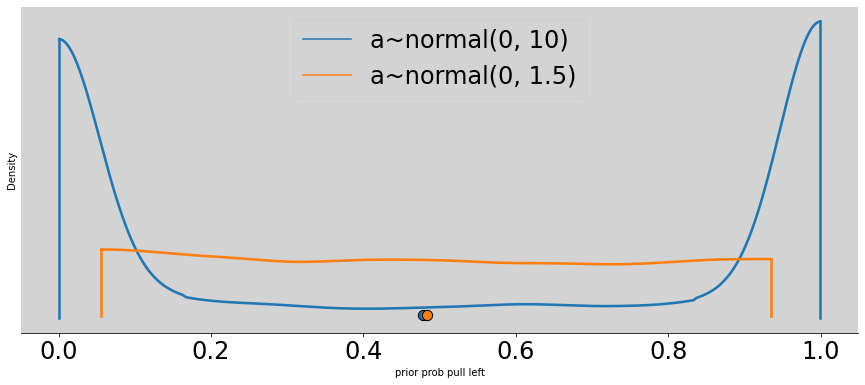

In [14]:
p = inv_logit(norm_prior)

omega = 1.5

better_p = inv_logit( np.random.normal(0, omega, N) ) 

az.plot_density([p, better_p],
                data_labels=['a~normal(0, 10)', 'a~normal(0, 1.5)'], 
                figsize=(15, 6))

plt.title('')
plt.xlabel('prior prob pull left')
plt.ylabel('Density')

plt.show()

In [15]:
model_partial_better = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial_better = stan.build(model_partial_better, data=data_list_partial)
samples_partial_better = posteriori_partial_better.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Messages from stanc:


Warning in '/tmp/httpstan_3c88lfol/model_wfxyqjio.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_3c88lfol/model_wfxyqjio.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:  10% (800/8000)


Sampling:  35% (2800/8000)


Sampling:  60% (4800/8000)


Sampling:  85% (6800/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 0.000115 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.2e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 4.5e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.


  Adjust your expectations accordingly!


In [16]:
az.summary(samples_partial_better, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.335,0.230,-0.698,0.027,0.003,0.003,6221.0,3145.0,1.0
alpha[1],3.926,0.733,2.836,5.104,0.011,0.009,4498.0,2492.0,1.0
alpha[2],-0.623,0.247,-1.039,-0.242,0.003,0.002,7013.0,2992.0,1.0
alpha[3],-0.625,0.254,-1.036,-0.229,0.003,0.002,6910.0,3005.0,1.0
alpha[4],-0.331,0.232,-0.695,0.032,0.003,0.003,6917.0,2863.0,1.0
alpha[5],0.563,0.243,0.187,0.954,0.003,0.003,5784.0,2874.0,1.0
alpha[6],2.009,0.360,1.436,2.577,0.005,0.004,6087.0,2897.0,1.0


In [17]:
samples_parcial_better = az.from_pystan(
    posterior=samples_partial_better,
)

### R Code 11.7

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 10) $$

In [18]:
# quap code to get priori

### R Code 11.8

In [19]:
p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 10, (4, N))

p = [inv_logit(alpha + beta) for beta in betas]

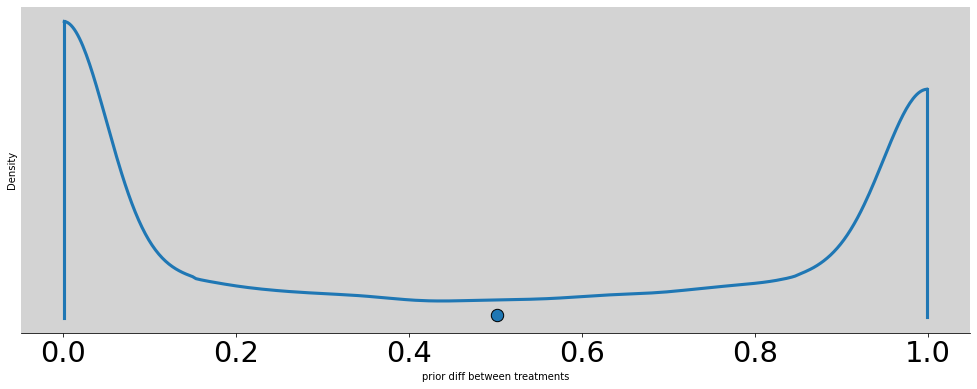

In [20]:
az.plot_density(np.absolute(p[0] - p[1]), figsize=(17, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.9

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 0.5) $$

In [21]:
better_p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 0.5, (4, N))

better_p = [inv_logit(alpha + beta) for beta in betas]

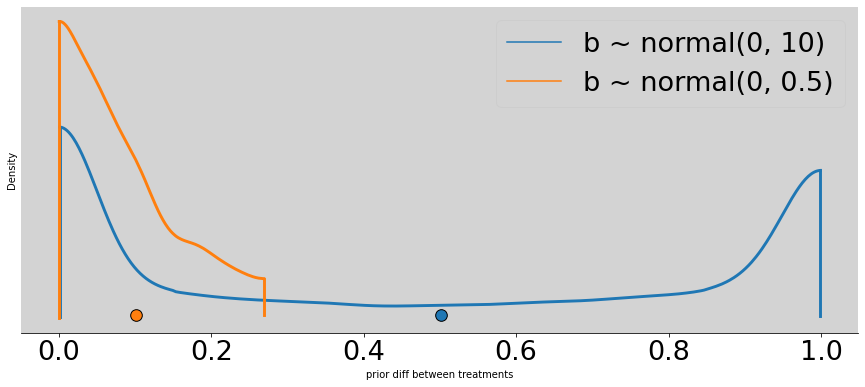

In [22]:
az.plot_density([
        np.absolute(p[0] - p[1]), 
        np.absolute(better_p[0] - better_p[1])
    ], 
    data_labels=['b ~ normal(0, 10)', 'b ~ normal(0, 0.5)'],
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

In [23]:
np.mean(np.absolute(better_p[0] - better_p[1]))

0.10040888662896558

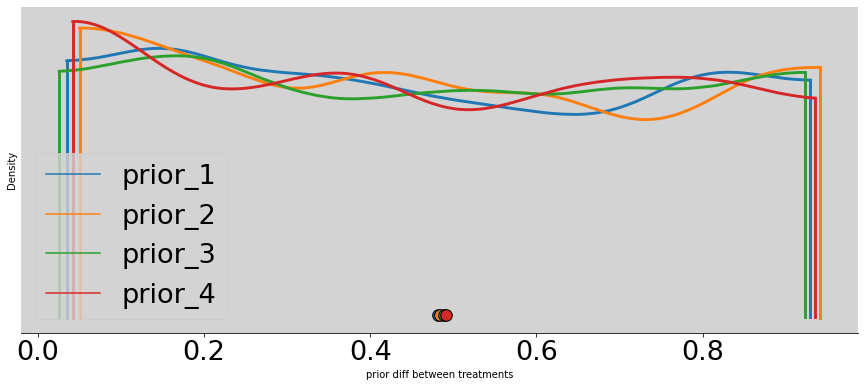

In [24]:
# Plot the 4 prior

az.plot_density([
        better_p[0], 
        better_p[1], 
        better_p[2], 
        better_p[3], 
    ],
    data_labels=['prior_1', 'prior_2', 'prior_3', 'prior_4'], 
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.10

In [25]:
data_list = df[['pulled_left', 'actor', 'treatment']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_chimpanzees'] = len(df.actor.unique())
data_list['qty_treatment'] = len(df.treatment.unique())

data_list.keys()

dict_keys(['pulled_left', 'actor', 'treatment', 'N', 'qty_chimpanzees', 'qty_treatment'])

### R Code 11.11

In [26]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_treatment;
        int pulled_left[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
        vector[qty_treatment] beta;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Messages from stanc:


Warning in '/tmp/httpstan_smhnkwpt/model_gqrwnfnu.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_smhnkwpt/model_gqrwnfnu.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_smhnkwpt/model_gqrwnfnu.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:   4% (300/8000)


Sampling:  10% (800/8000)


Sampling:  19% (1500/8000)


Sampling:  44% (3500/8000)


Sampling:  65% (5200/8000)


Sampling:  84% (6700/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 7.1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.4e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.


  Adjust your expectations accordingly!


In [27]:
samples_chimpanzees = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['pulled_left', 'actor', 'treatment']
)

In [28]:
az.summary(samples_chimpanzees, var_names=['alpha', 'beta'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.461,0.340,-1.003,0.072,0.008,0.006,1693.0,2221.0,1.0
alpha[1],3.899,0.745,2.798,5.136,0.013,0.009,3877.0,2485.0,1.0
alpha[2],-0.759,0.342,-1.265,-0.181,0.008,0.006,1654.0,2520.0,1.0
alpha[3],-0.757,0.337,-1.269,-0.205,0.008,0.006,1665.0,2450.0,1.0
alpha[4],-0.457,0.328,-0.944,0.100,0.008,0.006,1527.0,2448.0,1.0
alpha[5],0.460,0.336,-0.091,0.978,0.008,0.006,1758.0,2497.0,1.0
alpha[6],1.948,0.423,1.258,2.606,0.009,0.006,2220.0,2804.0,1.0
beta[0],-0.028,0.290,-0.494,0.424,0.008,0.005,1494.0,2154.0,1.0
beta[1],0.489,0.286,0.039,0.953,0.007,0.005,1501.0,2514.0,1.0
beta[2],-0.374,0.286,-0.813,0.088,0.008,0.005,1422.0,2233.0,1.0


### R Code 11.12

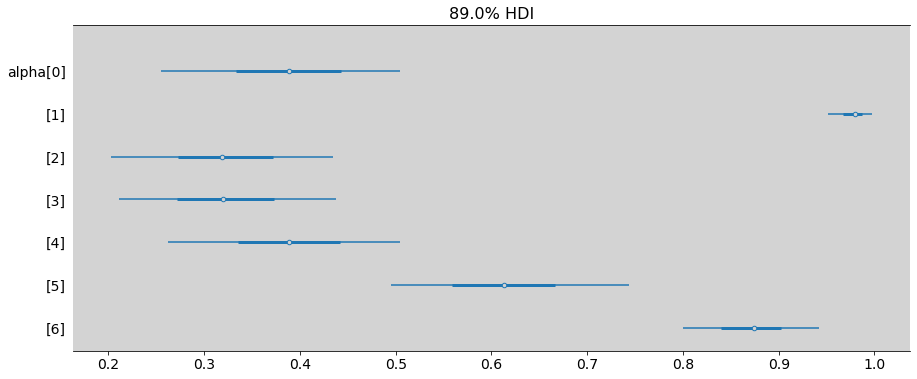

In [29]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

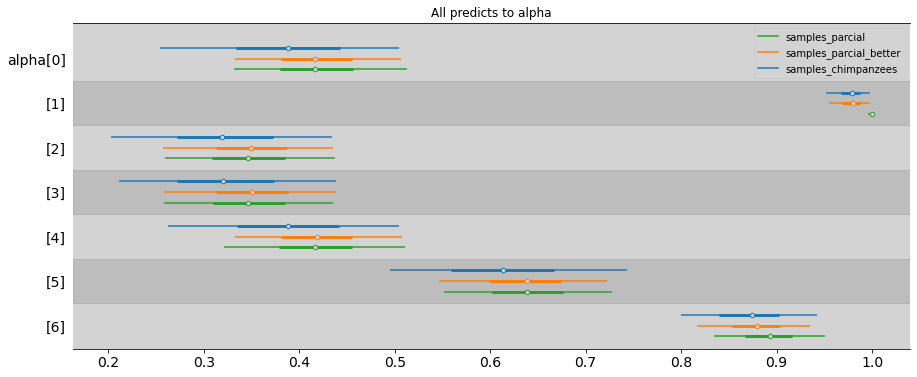

In [30]:
ax = az.plot_forest([samples_chimpanzees, samples_parcial_better, samples_partial], 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities,
                    model_names=['samples_chimpanzees', 'samples_parcial_better', 'samples_parcial'],
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

plt.title('All predicts to alpha')

plt.show()

### R Code 11.13

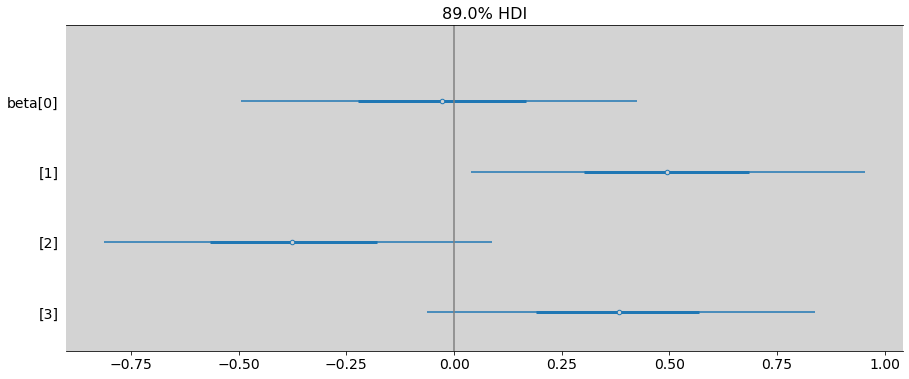

In [31]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))
plt.axvline(x=0, c='gray')
plt.show()

### R Code 8.14

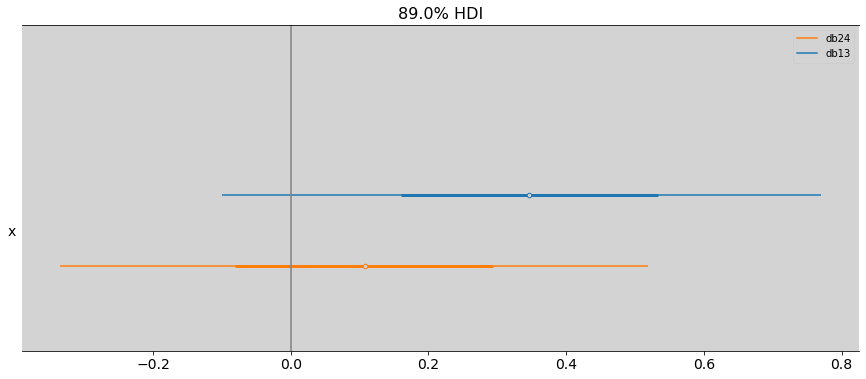

In [32]:
beta_0 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)
beta_1 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)
beta_2 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)
beta_3 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)

diff_beta_0_2 = az.extract(beta_0 - beta_2)
diff_beta_1_3 = az.extract(beta_1 - beta_3)

az.plot_forest(
    [diff_beta_0_2.beta.values, diff_beta_1_3.beta.values],
    combined=True,  # Joint all chains 
    kind="forestplot", # or ridgeplot to plot densities
    # transform=inv_logit,
    model_names=['db13', 'db24'],
    hdi_prob=0.89,
    figsize=(15, 6)
)

plt.axvline(x=0, c='gray')

plt.show()

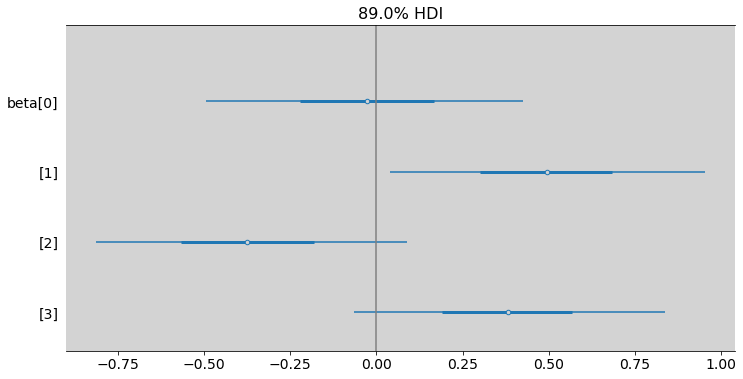

In [33]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(12, 6))

plt.axvline(x=0, c='gray')
plt.show()

### R Code 11.15

In [34]:
pl = df.groupby(['actor', 'treatment'])[['actor', 'treatment', 'pulled_left']].mean(['pulled_left'])

pl.loc[pl.actor == 1]

actor  treatment  pulled_left
actor treatment                               
1     1            1.0        1.0     0.333333
      2            1.0        2.0     0.500000
      3            1.0        3.0     0.277778
      4            1.0        4.0     0.555556

### R Code 11.16 and R Code 11.17

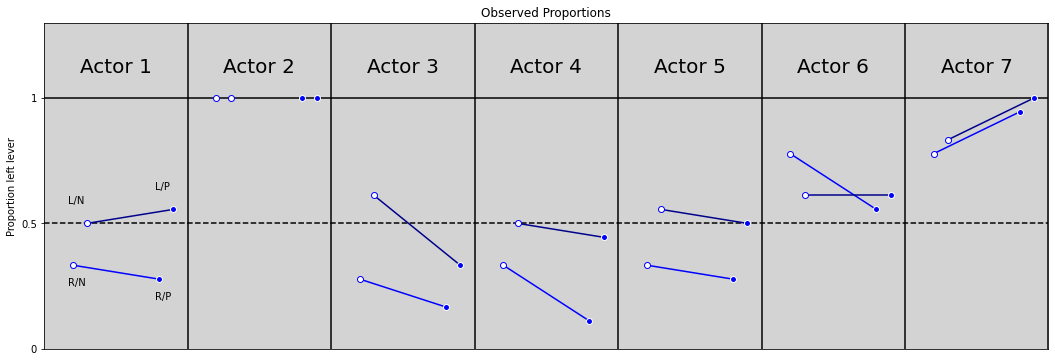

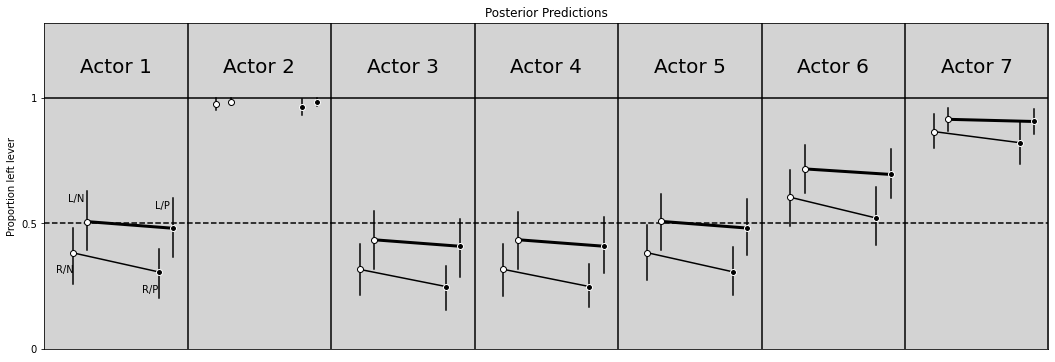

In [35]:
# R Code 11.16

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    RN, LN, RP, LP = pl.loc[pl.actor == i + 1, 'pulled_left'].values

    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN, RP], color='blue')
    plt.plot(0.2 + i, RN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.8 + i, RP, 'o', markerfacecolor='blue', color='white')
    
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN, LP], color='darkblue')
    plt.plot(0.3 + i, LN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.9 + i, LP, 'o', markerfacecolor='blue', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.17, y=RN - 0.08, s='R/N')
        plt.text(x=0.77, y=RP - 0.08, s='R/P')
        plt.text(x=0.17, y=LN + 0.08, s='L/N')
        plt.text(x=0.77, y=LP + 0.08, s='L/P')
    
plt.title('Observed Proportions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()


# R Code 11.17
# ============

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    alpha_chimp = az.extract(samples_chimpanzees.posterior.alpha.sel(alpha_dim_0=i)).alpha.values
    
    RN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)).beta.values)
    LN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values)
    RP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)).beta.values)
    LP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values)
    
    # To R/N and R/P
    # ===============
    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN.mean(), RP.mean()], color='black')
    
    # Plot hdi compatibility interval
    RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
    RP_hdi_min, RP_hdi_max = az.hdi(RP, hdi_prob=0.89)
    plt.plot([0.2 + i, 0.2 + i], [RN_hdi_min, RN_hdi_max], c='black')
    plt.plot([0.8 + i, 0.8 + i], [RP_hdi_min, RP_hdi_max], c='black')
    
    # Plot points
    plt.plot(0.2 + i, RN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.8 + i, RP.mean(), 'o', markerfacecolor='black', color='white')
    
    # To L/N and L/P
    # ===============
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN.mean(), LP.mean()], color='black', linewidth=3)

    # Plot hdi compatibility interval
    LN_hdi_min, LN_hdi_max = az.hdi(LN, hdi_prob=0.89)
    LP_hdi_min, LP_hdi_max = az.hdi(LP, hdi_prob=0.89)
    plt.plot([0.3 + i, 0.3 + i], [LN_hdi_min, LN_hdi_max], c='black')
    plt.plot([0.9 + i, 0.9 + i], [LP_hdi_min, LP_hdi_max], c='black')

    plt.plot(0.3 + i, LN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.9 + i, LP.mean(), 'o', markerfacecolor='black', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.08, y=RN.mean() - 0.08, s='R/N')
        plt.text(x=0.68, y=RP.mean() - 0.08, s='R/P')
        plt.text(x=0.17, y=LN.mean() + 0.08, s='L/N')
        plt.text(x=0.77, y=LP.mean() + 0.08, s='L/P')
    
plt.title('Posterior Predictions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()

### R Code 11.18

In [36]:
df['side'] = df.prosoc_left + 1  # Right 1, Left 2  - Because R start index in 1
df['cond'] = df.condition + 1  # no partner 1, partner 2 - Because R start index in 1

### R Code 11.19

In [37]:
# Creating data list 2 to model
data_list2 = df[['pulled_left', 'actor', 'side', 'cond']].to_dict('list')
data_list2['N'] = len(df)
data_list2['qty_actors'] = len(df.actor.unique())
data_list2['qty_side'] = len(df.side.unique())
data_list2['qty_cond'] = len(df.cond.unique())

data_list2.keys()

dict_keys(['pulled_left', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_side', 'qty_cond'])

In [38]:
model2 = """
    data {
        int N;
        int qty_actors;
        int qty_side;
        int qty_cond;
        
        int pulled_left[N];
        int actor[N];
        int side[N];
        int cond[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_side] bs;
        vector[qty_cond] bc;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        bs ~ normal(0, 0.5);
        bc ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + bs[ side[i] ] + bc[ cond[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori2 = stan.build(model2, data=data_list2)
samples2 = posteriori2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Messages from stanc:


Warning in '/tmp/httpstan_hhpubees/model_cz77fau4.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_hhpubees/model_cz77fau4.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_hhpubees/model_cz77fau4.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_hhpubee

Sampling:   0%


Sampling:   0% (1/8000)


Sampling:   1% (101/8000)


Sampling:   3% (201/8000)


Sampling:   5% (401/8000)


Sampling:  10% (800/8000)


Sampling:  15% (1200/8000)


Sampling:  21% (1700/8000)


Sampling:  26% (2100/8000)


Sampling:  32% (2600/8000)


Sampling:  38% (3000/8000)


Sampling:  55% (4400/8000)


Sampling:  72% (5800/8000)


Sampling:  86% (6900/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 0.000181 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000103 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.03 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.00015 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.5 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.00011 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.


  Adjust your expectations accordingly!


In [39]:
samples_chimpanzees_2 = az.from_pystan(
    posterior_model=posteriori2,
    posterior=samples2,
    observed_data=['pulled_left', 'actor', 'side', 'cond']
)

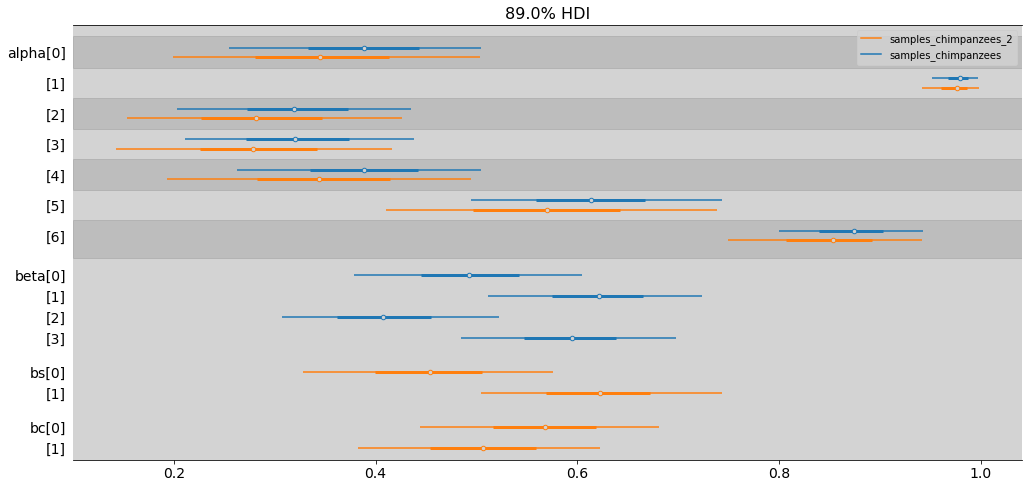

In [40]:
ax = az.plot_forest([samples_chimpanzees, samples_chimpanzees_2],
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha', 'beta', 'bs', 'bc'], 
                    model_names=['samples_chimpanzees', 'samples_chimpanzees_2'],
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(17, 8))
plt.show()

### R Code 11.21

To viewing data from rethinking packages

### R Code 11.22

Comparing two models

### R Code 11.23

In [41]:
beta_4 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values
beta_2 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values

np.mean( np.exp(beta_4 - beta_2) )

0.9304928624024834

### R Code 11.24

In [42]:
d = pd.read_csv('./data/chimpanzees.csv', sep=';')
d['treatment'] = 1 + d['prosoc_left'] + 2 * d['condition']
d['side'] = d['prosoc_left'] + 1  # right 1, left 2
d['cond'] = d['condition'] + 1  # no partner 1, partner 2

d_aggregate = d.groupby(['treatment', 'actor', 'side', 'cond'])[['pulled_left']].sum('pulled_left').copy()
d_aggregate.rename(columns={'pulled_left': 'left_pulls'}, inplace=True)  # Rename columns
d_aggregate.reset_index(inplace=True)
d_aggregate.head(8)

,treatment,actor,side,cond,left_pulls
0,1,1,1,1,6
1,1,2,1,1,18
2,1,3,1,1,5
3,1,4,1,1,6
4,1,5,1,1,6
5,1,6,1,1,14
6,1,7,1,1,14
7,2,1,2,1,9


In [43]:
len(d_aggregate)

28

### R Code 11.25

In [44]:
dat = d_aggregate[['left_pulls', 'treatment', 'actor', 'side', 'cond']].to_dict('list')
dat['N'] = len(d_aggregate)
dat['qty_actors'] = len(d_aggregate.actor.unique())
dat['qty_treatments'] = len(d_aggregate.treatment.unique())

dat.keys()

dict_keys(['left_pulls', 'treatment', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_treatments'])

In [45]:
model = """
    data {
        int N;
        int qty_actors;
        int qty_treatments;
        
        int left_pulls[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_treatments] beta;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        left_pulls ~ binomial(18, p);
    }
"""

posteriori = stan.build(model, data=dat)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp: In constructor ‘model_oarnjyr4_namespace::model_oarnjyr4::model_oarnjyr4(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp:58:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   58 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 11.8s


Building: 11.9s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.0s


Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp: In instantiation of ‘void model_oarnjyr4_namespace::model_oarnjyr4::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp:467:36:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp:260:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  260 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp: In instantiation of ‘void model_oarnjyr4_namespace::model_oarnjyr4::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 12.5s


Building: 12.6s


Building: 12.7s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.8s


Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp: In instantiation of ‘void model_oarnjyr4_namespace::model_oarnjyr4::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oarnjyr4/model_oarnjyr4.cpp:413:5:   required from ‘void model_oarnjyr4_namespace::model_oarnjyr4::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.4s


Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.9s


Building: 28.0s


Building: 28.1s


Building: 28.1s, done.


Messages from stanc:


Warning in '/tmp/httpstan_8w0xo0dq/model_oarnjyr4.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_8w0xo0dq/model_oarnjyr4.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_8w0xo0dq/model_oarnjyr4.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_8w0xo0dq

Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 1.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 2e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.


  Adjust your expectations accordingly!


In [46]:
model_chimp_bin = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['left_pulls', 'treatment', 'actor'],
)

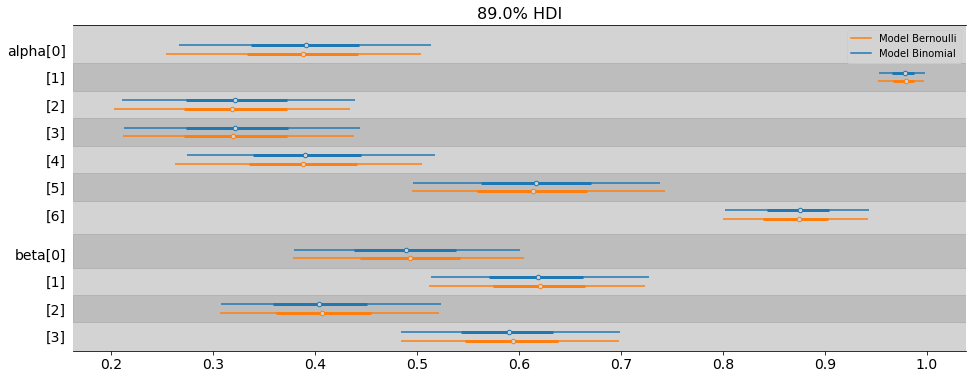

In [47]:
az.plot_forest(
    [model_chimp_bin, samples_chimpanzees],
    var_names=['alpha', 'beta'], 
    model_names=['Model Binomial', 'Model Bernoulli'],
    combined=True, 
    transform=inv_logit, 
    figsize=(16, 6),
    hdi_prob=0.89,
)

plt.show()

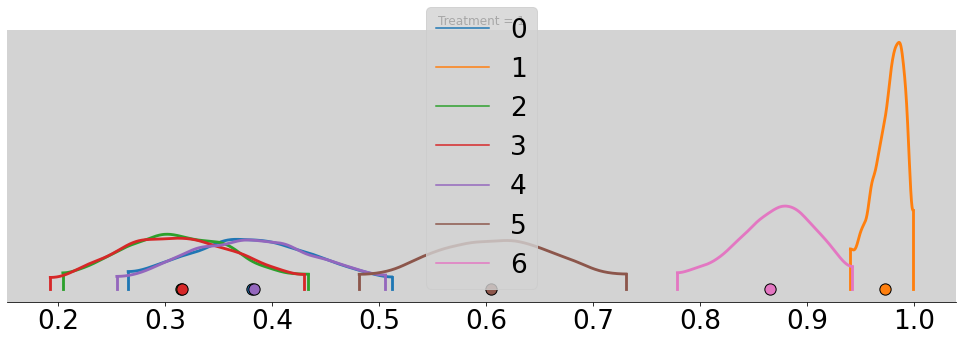

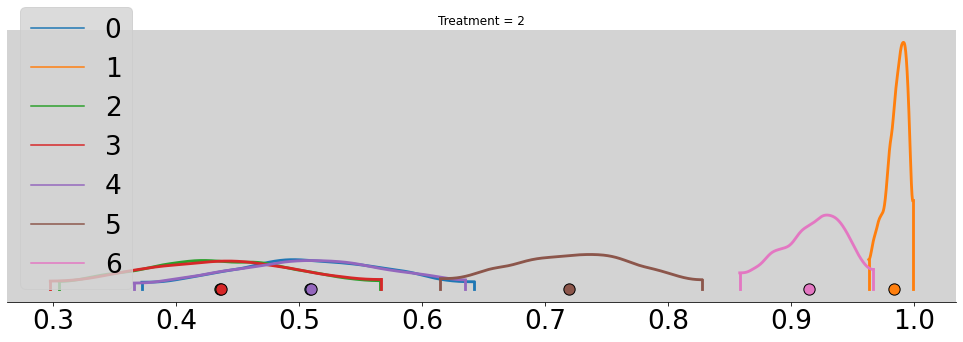

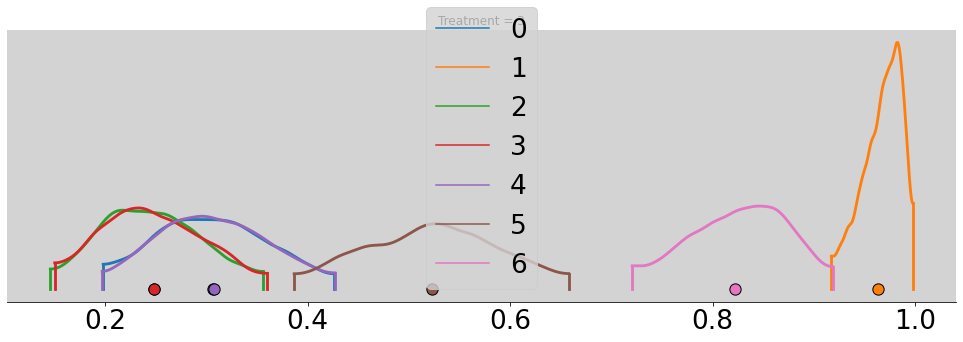

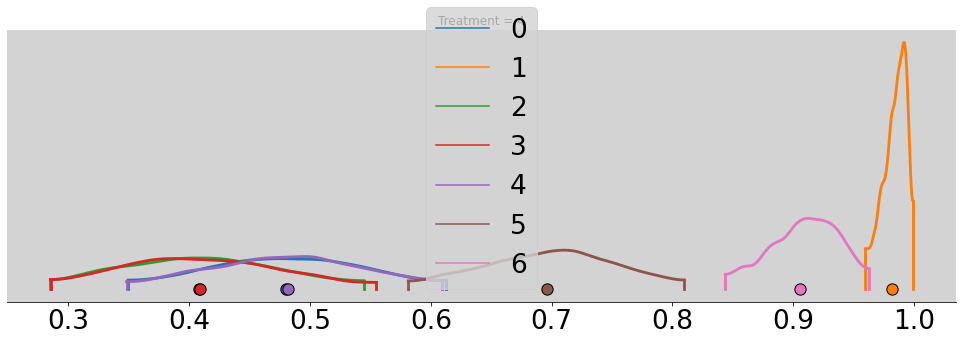

In [48]:
for t in range(4):
    p_chimp_bin = []
    for i in range(7):
        alpha_chimp_bin = model_chimp_bin.posterior.alpha.sel(alpha_dim_0=i).values.flatten()
        beta_chimp_bin = model_chimp_bin.posterior.beta.sel(beta_dim_0=t).values.flatten()

        p_chimp_bin.append(inv_logit(alpha_chimp_bin + beta_chimp_bin))

    az.plot_density(p_chimp_bin, figsize=(17, 5))
    plt.title(f'Treatment = {t + 1}')

plt.show()

### R Code 11.26

In [49]:
models_to_compare = {'model_chimp_bin': model_chimp_bin, 'samples_chimpanzees': samples_chimpanzees}

# az.compare(models_to_compare)  # or use 'elpd_waic' to WAIC

# XXX: Need to make posteriori in model to read in arviz

### R Code 11.27

In [50]:
# Deviance of aggregated 6-in-9
agg = -2 * np.log(stats.binom.pmf(k=6, n=9, p=0.2))
print(agg)

# Deviance of dis-aggregagted
k = [1, 1, 1, 1, 1, 1, 0, 0, 0]

not_agg = -2 * np.sum(np.log(stats.bernoulli.pmf(k=k, p=0.2)))
print(not_agg)

11.790482659407832
20.652116257094463


-----------

### My Tests

In [51]:
N = 100
p = np.random.rand()

y = np.random.binomial(1, p, N)

In [52]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(1, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.1s


Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp: In constructor ‘model_ejgqoum2_namespace::model_ejgqoum2::model_ejgqoum2(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp:43:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   43 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
              

Building: 11.8s


Building: 11.9s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:57:   required from ‘auto stan::math::grad_2F1(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool ReturnSameT = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_v

Building: 12.0s


Building: 12.1s


Building: 12.3s


Building: 12.4s


Building: 12.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp: In instantiation of ‘void model_ejgqoum2_namespace::model_ejgqoum2::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp:308:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp:201:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  201 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp: In instantiation of ‘void model_ejgqoum2_namespace::model_ejgqoum2::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp: In instantiation of ‘void model_ejgqoum2_namespace::model_ejgqoum2::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ejgqoum2/model_ejgqoum2.cpp:264:5:   required from ‘void model_ejgqoum2_namespace::model_ejgqoum2::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.6s, done.


Messages from stanc:


Warning in '/tmp/httpstan_zuq52tlj/model_ejgqoum2.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.9e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.4e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.


  Adjust your expectations accordingly!


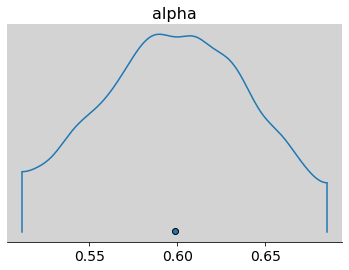

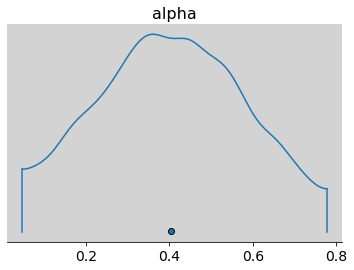

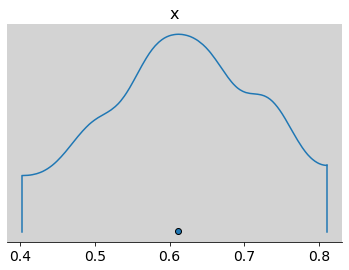

In [53]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

az.plot_density(inv_logit(np.random.normal(0.5, 0.5, 1000)))  # Priori

plt.show()

In [54]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.6395421321747394 0.5988337119128063


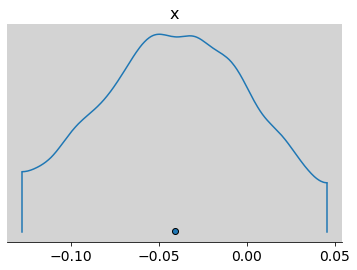

In [55]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()

In [56]:
# Binomial

N = 100
p = np.random.rand()

y = np.random.binomial(5, p, N)

In [57]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(5, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.1s


Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp: In constructor ‘model_sf6cbrno_namespace::model_sf6cbrno::model_sf6cbrno(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp:43:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   43 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
              

Building: 11.9s


Building: 12.0s


Building: 12.1s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:57:   required from ‘auto stan::math::grad_2F1(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool ReturnSameT = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_v

Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp: In instantiation of ‘void model_sf6cbrno_namespace::model_sf6cbrno::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp:308:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp:201:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  201 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp: In instantiation of ‘void model_sf6cbrno_namespace::model_sf6cbrno::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


Building: 16.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp: In instantiation of ‘void model_sf6cbrno_namespace::model_sf6cbrno::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/sf6cbrno/model_sf6cbrno.cpp:264:5:   required from ‘void model_sf6cbrno_namespace::model_sf6cbrno::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.7s, done.


Messages from stanc:


Warning in '/tmp/httpstan_eib0fyvl/model_sf6cbrno.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 2.1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.


  Adjust your expectations accordingly!


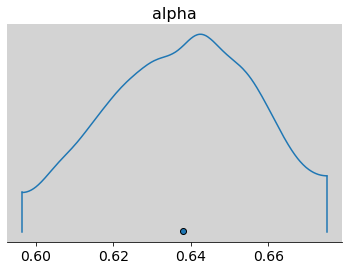

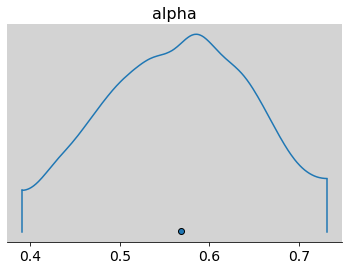

In [58]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

plt.show()

In [59]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.679474227457576 0.6379739000951222


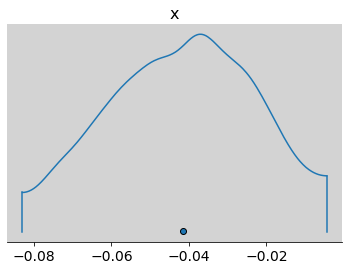

In [60]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()

-----------

### R Code 11.28

In [61]:
df = pd.read_csv('./data/UCBadmit.csv', sep=';')
df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [62]:
total_male_applic = df[df['applicant.gender']  == 'male']['applications'].sum()
total_male_admit = df[df['applicant.gender']  == 'male']['admit'].sum()
print('Percentual total male =', int(100*(total_male_admit / total_male_applic)), '%')

total_female_applic = df[df['applicant.gender']  == 'female']['applications'].sum()
total_female_admit = df[df['applicant.gender']  == 'female']['admit'].sum()
print('Percentual total female =', int(100*(total_female_admit / total_female_applic)), '%')

Percentual total male = 44 %
Percentual total female = 30 %


### R Code 11.29

$$ A_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{GID[i]} $$

$$ \alpha_j \sim Normal(0, 1.5) $$

In [63]:
df['gid'] = np.where(df['applicant.gender'] == 'male', 1, 2)

dat_list = df[['admit', 'applications', 'gid']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_genders'] = len(df.gid.unique())
dat_list

{'admit': [512, 89, 353, 17, 120, 202, 138, 131, 53, 94, 22, 24],
 'applications': [825, 108, 560, 25, 325, 593, 417, 375, 191, 393, 373, 341],
 'gid': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 'N': 12,
 'qty_genders': 2}

In [64]:
for dept_i in df.dept.unique():
    
    print(f'DEPARTMENT ---> {dept_i}')
        
    for gend_i in ['male', 'female']:
    
        applications = df[(df['dept'] == dept_i) & (df['applicant.gender'] == gend_i)]['applications']
        admit = df[(df['dept'] == dept_i) & (df['applicant.gender'] == gend_i)]['admit']
        perc_admit = admit.values / applications.values

        print(f'The dept {dept_i} has {int(100 * perc_admit[0])}% acceptions rate for {gend_i}')
        
    print('\n')


DEPARTMENT ---> A
The dept A has 62% acceptions rate for male
The dept A has 82% acceptions rate for female


DEPARTMENT ---> B
The dept B has 63% acceptions rate for male
The dept B has 68% acceptions rate for female


DEPARTMENT ---> C
The dept C has 36% acceptions rate for male
The dept C has 34% acceptions rate for female


DEPARTMENT ---> D
The dept D has 33% acceptions rate for male
The dept D has 34% acceptions rate for female


DEPARTMENT ---> E
The dept E has 27% acceptions rate for male
The dept E has 23% acceptions rate for female


DEPARTMENT ---> F
The dept F has 5% acceptions rate for male
The dept F has 7% acceptions rate for female




In [65]:
model = """
    data {
        int N;
        int qty_genders;
        
        int admit[N];
        int applications[N];
        int gid[N];
    }
    
    parameters {
        vector[qty_genders] alpha;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ gid[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        admit ~ binomial(applications, p);
    }
"""

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp: In constructor ‘model_4b5grp4g_namespace::model_4b5grp4g::model_4b5grp4g(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp:53:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   53 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 11.8s


Building: 11.9s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.0s


Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp: In instantiation of ‘void model_4b5grp4g_namespace::model_4b5grp4g::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp:395:36:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp:227:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  227 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp: In instantiation of ‘void model_4b5grp4g_namespace::model_4b5grp4g::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 12.5s


Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp: In instantiation of ‘void model_4b5grp4g_namespace::model_4b5grp4g::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/4b5grp4g/model_4b5grp4g.cpp:341:5:   required from ‘void model_4b5grp4g_namespace::model_4b5grp4g::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s, done.


Messages from stanc:


Warning in '/tmp/httpstan_2frew54l/model_4b5grp4g.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_2frew54l/model_4b5grp4g.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_2frew54l/model_4b5grp4g.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 1.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 8e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 5e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.


  Adjust your expectations accordingly!


In [66]:
app_gender = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=list(dat_list.keys()),
    dims={
        'alpha': ['gender'],
    }
)

In [67]:
az.summary(app_gender)  # In scale inv-logit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.22,0.039,-0.287,-0.143,0.001,0.000,3893.0,2712.0,1.0
alpha[1],-0.83,0.050,-0.921,-0.733,0.001,0.001,4089.0,2650.0,1.0


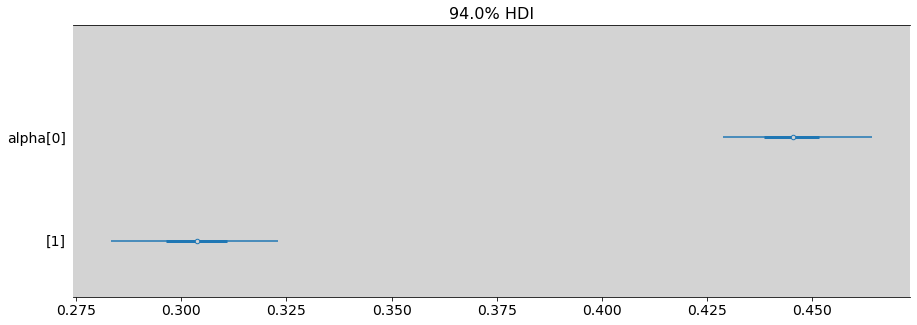

In [68]:
az.plot_forest(app_gender, var_names=['alpha'], combined=True, figsize=(15,5), transform=inv_logit)
plt.show()

### R Code 11.30

In [69]:
alpha_1 = app_gender.posterior.alpha.sel(gender=0)
alpha_2 = app_gender.posterior.alpha.sel(gender=1)

diff_a = alpha_1 - alpha_2
diff_p = inv_logit(alpha_1) - inv_logit(alpha_2)

az.summary(diff_a)  # Shark

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.61,0.065,0.49,0.734,0.001,0.001,4040.0,2912.0,1.0


In [70]:
az.summary(diff_p)  # Deer

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.141,0.015,0.114,0.169,0.0,0.0,4030.0,2886.0,1.0


### R Code 11.31

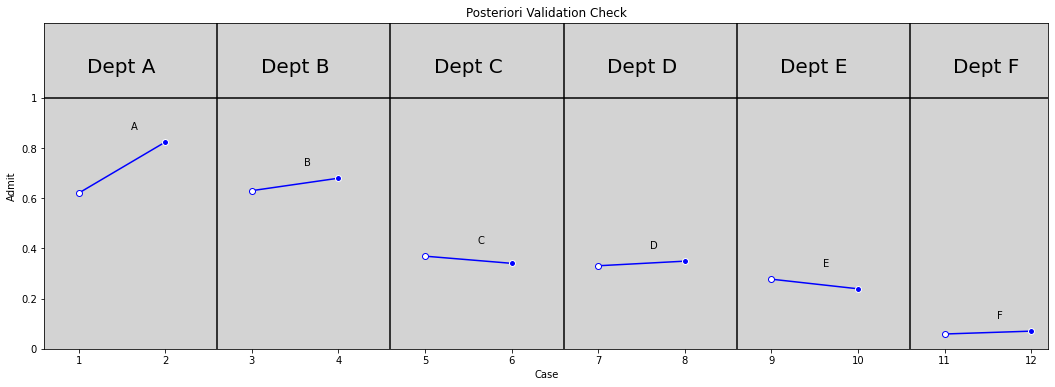

In [71]:
plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 5.8)
plt.axhline(y=1, ls='-', c='black')

depts = df.dept.unique()

for i in range(6):
    plt.axvline(x=i+1, c='black')
    
    dept = depts[i]

    plt.text(x=i + 0.25, y=1.1, s=f'Dept {dept}', size=20)

    perc_male, perc_female = df.loc[df['dept'] == dept, 'admit'] / df.loc[df['dept'] == dept, 'applications']

    plt.plot([0.2 + i, 0.7 + i], [perc_male, perc_female], color='blue')  # Line
    plt.plot(0.2 + i, perc_male, 'o', markerfacecolor='white', color='blue')  # point male
    plt.plot(0.7 + i, perc_female, 'o', markerfacecolor='blue', color='white')  # point female
    
    plt.text(x=0.5 + i, y=max(perc_male, perc_female) + 0.05, s=dept)
    
plt.title('Posteriori Validation Check')
plt.ylabel('Admit')
plt.xlabel('Case')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks(np.arange(0, 5.9, 0.5) + 0.2, np.arange(1, 12.1, 1, dtype=int))

plt.show()

# Need put points with open points from samples

### R Code 11.32

We want ask:

    - What is the average difference in probability of admission between women and man within departments?

$$ A_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{GID[i]} + \delta_{DEPT[i]} $$

$$ \alpha_j \sim Normal(0, 1.5) $$

$$ \delta_k \sim Normal(0, 1.5) $$

In [72]:
df['gid'] = np.where(df['applicant.gender'] == 'male', 1, 2)

df['dept_idx'] = [ord(dept_i) - 64 for dept_i in df['dept']]  # ord('A') = 65

dat_list = df[['admit', 'applications', 'gid', 'dept_idx']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_genders'] = len(df.gid.unique())
dat_list['qty_dept'] = len(df.dept_idx.unique())

dat_list

{'admit': [512, 89, 353, 17, 120, 202, 138, 131, 53, 94, 22, 24],
 'applications': [825, 108, 560, 25, 325, 593, 417, 375, 191, 393, 373, 341],
 'gid': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 'dept_idx': [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6],
 'N': 12,
 'qty_genders': 2,
 'qty_dept': 6}

In [73]:
model = """
    data {
        int N;
        int qty_genders;
        int qty_dept;
        
        array[N] int admit;
        array[N] int applications;
        array[N] int gid;
        array[N] int dept_idx;
    }
    
    parameters {
        vector[qty_genders] alpha;
        vector[ qty_dept ] delta;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        delta ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ gid[i] ] + delta[ dept_idx[i] ];  # O Delta calcula a taxa média de admissão para o departamento i
            p[i] = inv_logit(p[i]);
        }
        
        admit ~ binomial(applications, p);
    }
"""

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


Building: 11.8s


/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp: In constructor ‘model_fjuqsl5p_namespace::model_fjuqsl5p::model_fjuqsl5p(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp:61:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   61 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 11.9s


Building: 12.0s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp: In instantiation of ‘void model_fjuqsl5p_namespace::model_fjuqsl5p::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp:475:36:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp:270:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  270 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp: In instantiation of ‘void model_fjuqsl5p_namespace::model_fjuqsl5p::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp: In instantiation of ‘void model_fjuqsl5p_namespace::model_fjuqsl5p::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/fjuqsl5p/model_fjuqsl5p.cpp:421:5:   required from ‘void model_fjuqsl5p_namespace::model_fjuqsl5p::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.8s


Building: 27.9s


Building: 28.0s


Building: 28.1s


Building: 28.2s


Building: 28.3s


Building: 28.4s, done.


Messages from stanc:


Warning in '/tmp/httpstan_zam1t08i/model_fjuqsl5p.stan', line 25, column 60: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.33.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 7e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 5e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 7e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 7e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.


  Adjust your expectations accordingly!


In [74]:
applic_gender_2 = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=list(dat_list.keys()),
    dims = {
        'alpha': ['gender'],
        'delta': ['department'],
    }
)

In [75]:
az.summary(applic_gender_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.602,0.521,-1.479,0.429,0.03,0.021,309.0,552.0,1.0
alpha[1],-0.506,0.523,-1.420,0.482,0.03,0.021,307.0,582.0,1.0
delta[0],1.183,0.525,0.229,2.153,0.03,0.021,311.0,597.0,1.0
delta[1],1.138,0.527,0.141,2.098,0.03,0.021,313.0,618.0,1.0
delta[2],-0.076,0.524,-1.036,0.880,0.03,0.021,309.0,579.0,1.0
delta[3],-0.108,0.525,-1.055,0.858,0.03,0.021,308.0,575.0,1.0
delta[4],-0.552,0.528,-1.580,0.371,0.03,0.021,307.0,621.0,1.0
delta[5],-2.111,0.538,-3.131,-1.141,0.03,0.021,323.0,623.0,1.0


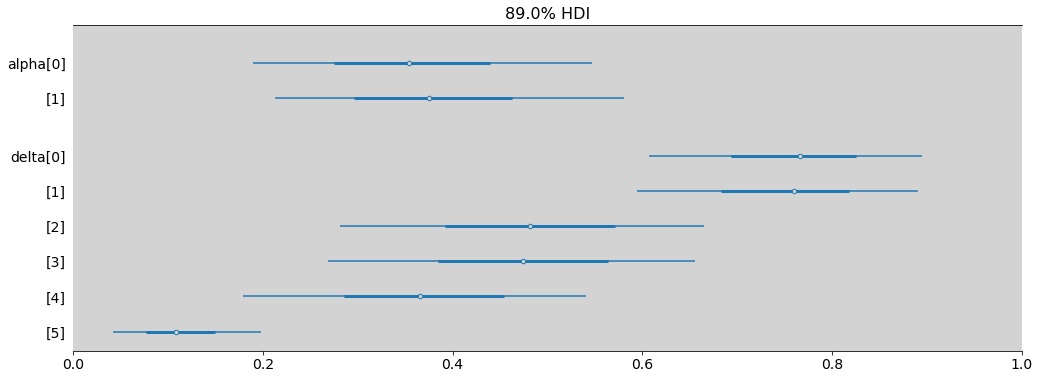

In [76]:
az.plot_forest(
    applic_gender_2,
    var_names=['alpha', 'delta'],
    combined=True,
    transform=inv_logit,
    figsize=(17, 6),
    hdi_prob=0.89,
)

plt.xlim((0, 1))
plt.show()

### R Code 11.33

In [77]:
alpha_male = applic_gender_2.posterior.alpha.sel(gender=0)
alpha_female = applic_gender_2.posterior.alpha.sel(gender=1)

az.summary(alpha_male - alpha_female, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.096,0.081,-0.223,0.035,0.001,0.001,4495.0,3760.0,1.0


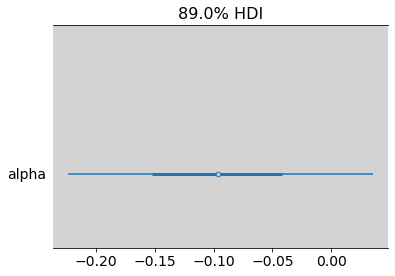

In [78]:
az.plot_forest((alpha_male - alpha_female), hdi_prob=0.89, combined=True)
plt.show()

In [79]:
az.summary(inv_logit(alpha_male) - inv_logit(alpha_female), hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.021,0.018,-0.05,0.008,0.0,0.0,3438.0,3591.0,1.0


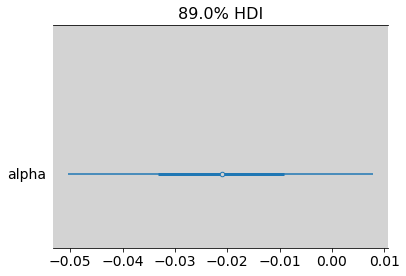

In [80]:
az.plot_forest((inv_logit(alpha_male) - inv_logit(alpha_female)), hdi_prob=0.89, combined=True)
plt.show()

In [81]:
pg = {}
pg['male'] = {}
pg['female'] = {}

dept_i = 'A'

for dept_i in df['dept'].unique():

    total = df[df['dept'] == dept_i]['applications'].sum()
    total_male = df[(df['dept'] == dept_i) & (df['applicant.gender'] == 'male')]['applications'].sum()
    total_female = df[(df['dept'] == dept_i) & (df['applicant.gender'] == 'female')]['applications'].sum()

    pg['male'][dept_i] = round(total_male / total, 2)
    pg['female'][dept_i] = round(total_female / total, 2)
    
pd.DataFrame.from_dict(pg).T

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


## Poisson Regression

### R Code 11.35

In [82]:
N = 10000
p = 1/1000

y = np.random.binomial(N, p, 10000)
print(f'The mean is {np.mean(y)} and variance is {np.var(y)}')

The mean is 10.036 and variance is 10.078504


### R Code 11.36

In [83]:
df = pd.read_csv('./data/Kline.csv', sep=';')
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


$$ y_i \sim Poisson(\lambda) $$

The parameter $\lambda$ is expected value of the outcome y.

The *link function* for poisson is the $log$ link.

$$ y_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha + \beta(x_i - \bar x) $$

### R Code 11.37

In [84]:
df['log_population'] = np.log(df['population'])  # log population
df['P'] = (df['log_population'] - np.mean(df['log_population'])) / np.std(df['log_population'])  #std log population
df['contact_id'] = [2 if contact_i == 'high' else 1 for contact_i in df['contact'].values ]  # CID 1:low; 2:high
df

,culture,population,contact,total_tools,mean_TU,log_population,P,contact_id
0,Malekula,1100,low,13,3.2,7.003065,-1.361332,1
1,Tikopia,1500,low,22,4.7,7.313220,-1.147433,1
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.543664,1
3,Yap,4791,high,43,5.0,8.474494,-0.346558,2
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.046737,2
5,Trobriand,8000,high,19,4.0,8.987197,0.007029,2
6,Chuuk,9200,high,40,3.8,9.126959,0.103416,2
7,Manus,13000,low,28,6.6,9.472705,0.341861,1
8,Tonga,17500,high,55,5.4,9.769956,0.546861,2
9,Hawaii,275000,low,71,6.6,12.524526,2.446558,1


#### Model - Poisson Regression

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} + \beta_{CID[i]} log(P_i) $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_j \sim \mbox{to be determined} $$


-----

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha$$

$$ \alpha \sim Normal(0, 10) $$


### R Code 11.38

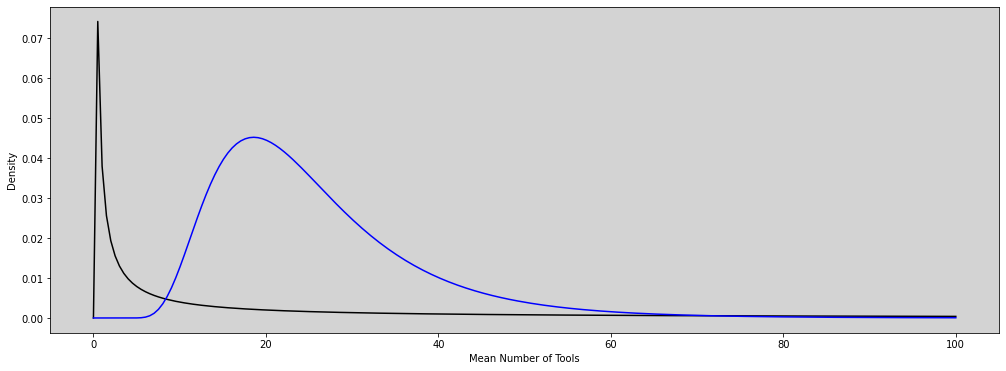

In [85]:
plt.figure(figsize=(17, 6))

N = 200
x = np.linspace(0, 100, N)

y = stats.lognorm.pdf(x=x, s=10, loc=0, scale=20)  # See the docs to understanding the parameters

# R Code 11.40
y_new = stats.lognorm.pdf(x=x, s=0.5, loc=3, scale=20)  # See the docs to understanding the parameters

plt.plot(x, y, c='black')
plt.plot(x, y_new, c='blue')

plt.ylabel('Density')
plt.xlabel('Mean Number of Tools')

plt.show()

### R Code 11.39

In [86]:
a = np.random.normal(0, 10, 1000)
lambda_ = np.exp(a)
np.mean(lambda_)

1877154437902.8613

### R Code 11.40

In [87]:
# Ploted in R Code 11.38

### R Code 11.41

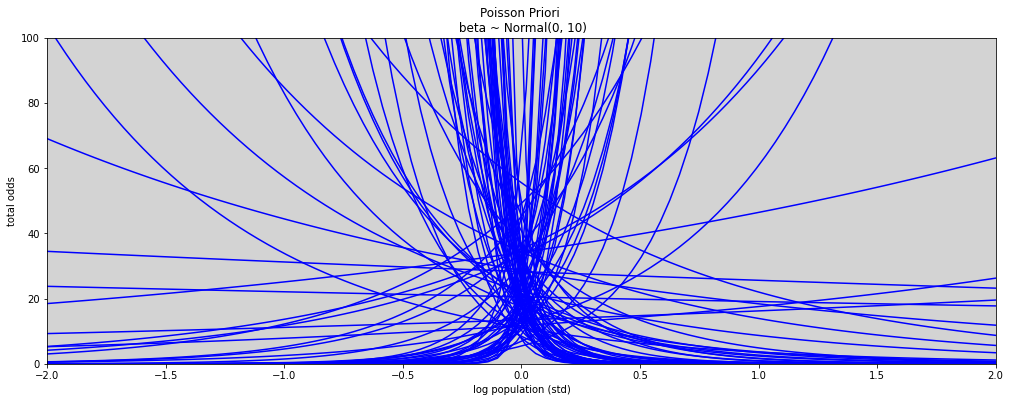

In [88]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 10, N)  # prior to beta

x = np.linspace(-2, 2, 100)

prioris = []

plt.figure(figsize=(17, 6))

for i in range(N):
    plt.plot(x, np.exp(a[i] + b[i] * x), c='blue')
    
plt.xlim(-2, 2)
plt.ylim(0, 100)

plt.title('Poisson Priori \n beta ~ Normal(0, 10)')
plt.xlabel('log population (std)')
plt.ylabel('total odds')
    
plt.show()

### R Code 11.42

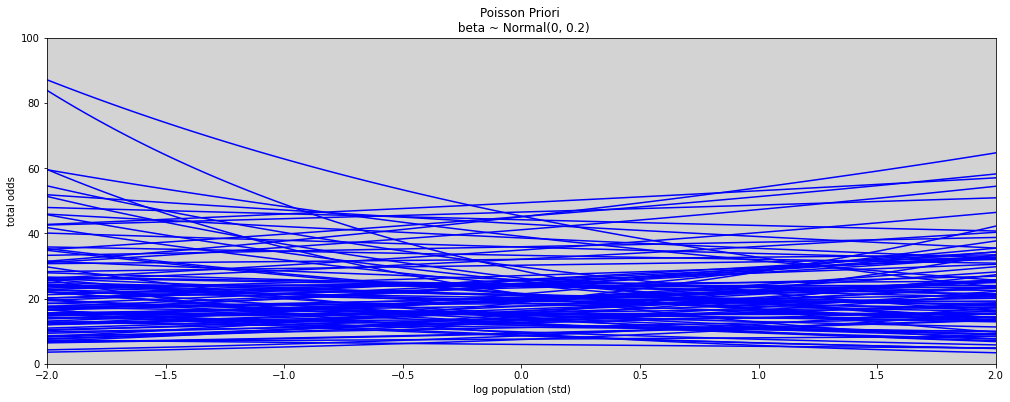

In [89]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 0.2, N)  # prior to beta

x = np.linspace(-2, 2, 100)

prioris = []

plt.figure(figsize=(17, 6))
for i in range(N):
    plt.plot(x, np.exp(a[i] + b[i] * x), c='blue')
    
plt.xlim(-2, 2)
plt.ylim(0, 100)

plt.title('Poisson Priori \n beta ~ Normal(0, 0.2)')
plt.xlabel('log population (std)')
plt.ylabel('total odds')

plt.show()

### R Code 11.43

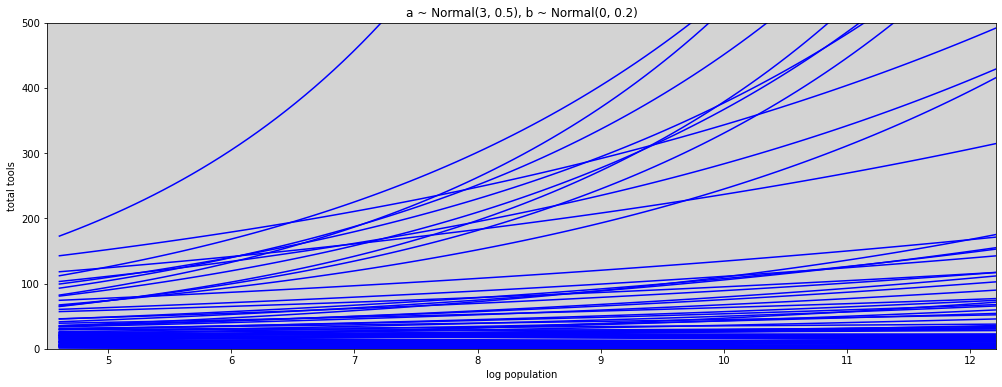

In [90]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 0.2, N)  # prior to beta

x_seq = np.linspace(np.log(100), np.log(200000), 100)  # log(population)

lambda_poisson =  [ np.exp(a[i] + b[i] * x_seq) for i in range(N) ]

plt.figure(figsize=(17,6))

for i in range(N):
    plt.plot(x_seq, lambda_poisson[i], c='blue')

plt.ylim(0, 500)
plt.xlim(min(x_seq) - 0.1, max(x_seq))

plt.title('a ~ Normal(3, 0.5), b ~ Normal(0, 0.2)')
plt.xlabel('log population')
plt.ylabel('total tools')

plt.show()

### R Code 11.44

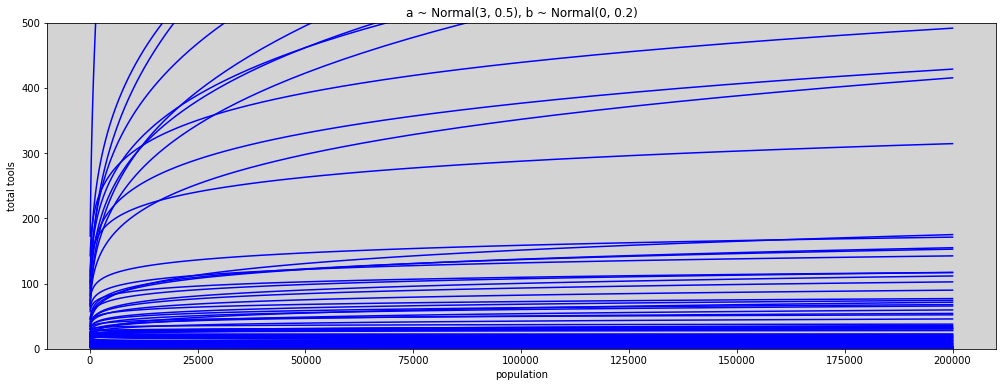

In [91]:
#N = 100
#a = np.random.normal(3, 0.5, N)  # prior to alpha
#b = np.random.normal(0, 0.2, N)  # prior to beta

x_seq = np.linspace(np.log(100), np.log(200000), 100)  # log(population)

lambda_poisson_ =  [ np.exp(a[i] + b[i] * x_seq) for i in range(N) ]

plt.figure(figsize=(17,6))

for i in range(N):
    plt.plot(np.exp(x_seq), lambda_poisson_[i], c='blue')

plt.ylim(0, 500)
#plt.xlim(min(np.exp(x_seq)), max(np.exp(x_seq)))

plt.title('a ~ Normal(3, 0.5), b ~ Normal(0, 0.2)')
plt.xlabel('population')
plt.ylabel('total tools')

plt.show()

#### Curiosidade do python

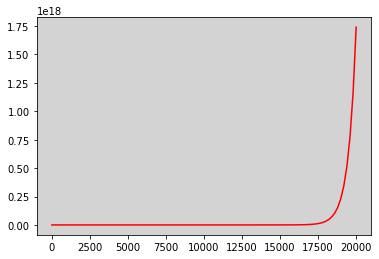

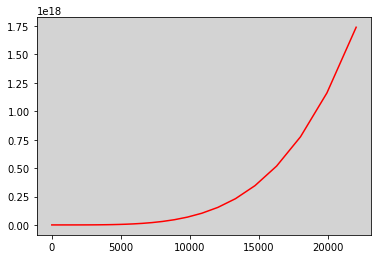

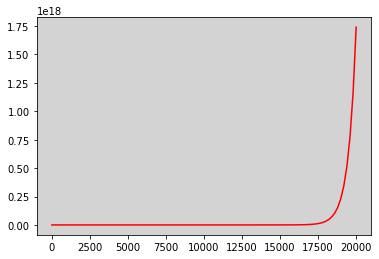

In [92]:
x = np.linspace(0, 10, 100)
y = np.exp(2 + 4 * x)

plt.plot(x*2000, y, c='red')
plt.show()

plt.plot(np.exp(x), y, c='red')
plt.show()

plt.plot(x*2000, y, c='red')
plt.show()

### R Code 11.45

#### Model:

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} $$

$$ \alpha_j \sim Normal(3, 0.5) $$


In [93]:
model_11_9 = """
    data {
        int N;
        array[N] int total_tools;
    }
    
    parameters {
        real alpha;
    }
    
    model {
        // Priori
        alpha ~ normal(3, 0.5);
        
        // Likelihood
        total_tools ~ poisson(exp(alpha));
    }
"""

data_list = df[['total_tools']].to_dict('list')
data_list['N'] = len(df)

posteriori = stan.build(model_11_9, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.1s


Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp: In constructor ‘model_ei2t26uq_namespace::model_ei2t26uq::model_ei2t26uq(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp:38:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   38 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
              

Building: 11.8s


Building: 11.9s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:57:   required from ‘auto stan::math::grad_2F1(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool ReturnSameT = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_v

Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp: In instantiation of ‘void model_ei2t26uq_namespace::model_ei2t26uq::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp:294:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp:187:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  187 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp: In instantiation of ‘void model_ei2t26uq_namespace::model_ei2t26uq::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp: In instantiation of ‘void model_ei2t26uq_namespace::model_ei2t26uq::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ei2t26uq/model_ei2t26uq.cpp:250:5:   required from ‘void model_ei2t26uq_namespace::model_ei2t26uq::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 3e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.


  Adjust your expectations accordingly!


In [94]:
model_11_9_post = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
)

In [95]:
az.summary(model_11_9_post, var_names=['alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.539,0.053,3.437,3.634,0.001,0.001,1653.0,2031.0,1.0


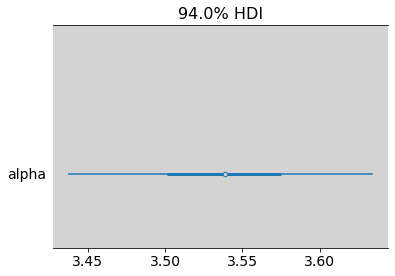

In [96]:
az.plot_forest(model_11_9_post, var_names=['alpha'], combined=True)
plt.show()

#### Model:

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} + \beta_{CID[i]} \times log(P_i) $$

$$ \alpha_j \sim Normal(3, 0.5) $$

$$ \beta_j \sim Normal(0, 0.2) $$

In [97]:
model_11_9_new = """
    data {
        int N;
        int qty_cid;
        array[N] int total_tools;
        array[N] real P;
        array[N] int contact_id;
    }
    
    parameters {
        array[qty_cid] real alpha;
        array[qty_cid] real beta;
    }
    
    model {
        vector[N] lambda;
        
        // Priori
        alpha ~ normal(3, 0.5);
        beta ~ normal(0, 0.2);
        
        // Likelihood
        for(i in 1:N){
                lambda[i] = alpha[ contact_id[i] ] + beta[ contact_id[i] ] * P[i];
                lambda[i] = exp(lambda[i]);
        }
        total_tools ~ poisson(lambda);
    }
"""

data_list = df[['total_tools', 'P', 'contact_id']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_cid'] = len(df.contact_id.unique())

posteriori = stan.build(model_11_9_new, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


Building: 11.8s


/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp: In constructor ‘model_oc34mlh7_namespace::model_oc34mlh7::model_oc34mlh7(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp:56:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   56 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 11.9s


Building: 12.0s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


Building: 12.6s


/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp: In instantiation of ‘void model_oc34mlh7_namespace::model_oc34mlh7::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp:412:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp:282:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  282 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp: In instantiation of ‘void model_oc34mlh7_namespace::model_oc34mlh7::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.7s


Building: 12.8s


Building: 13.0s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.4s


Building: 16.5s


Building: 16.6s


/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp: In instantiation of ‘void model_oc34mlh7_namespace::model_oc34mlh7::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/oc34mlh7/model_oc34mlh7.cpp:368:5:   required from ‘void model_oc34mlh7_namespace::model_oc34mlh7::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.8s


Building: 27.9s


Building: 28.0s


Building: 28.1s


Building: 28.2s


Building: 28.3s


Building: 28.4s


Building: 28.5s


Building: 28.6s


Building: 28.7s


Building: 28.8s


Building: 28.9s


Building: 29.0s


Building: 29.1s


Building: 29.2s


Building: 29.3s, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 6e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 5e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 6e-06 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.


  Adjust your expectations accordingly!


In [98]:
model_11_9_new_post = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
    dims={
        'alpha': ['contact_id'],
        'beta': ['contact_id'],
    }
)

In [99]:
az.summary(model_11_9_new_post)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],3.318,0.085,3.159,3.475,0.002,0.001,3218.0,3262.0,1.0
alpha[1],3.610,0.072,3.465,3.737,0.001,0.001,3837.0,2567.0,1.0
beta[0],0.361,0.049,0.265,0.449,0.001,0.001,3990.0,3160.0,1.0
beta[1],0.189,0.156,-0.123,0.468,0.003,0.002,3815.0,2813.0,1.0


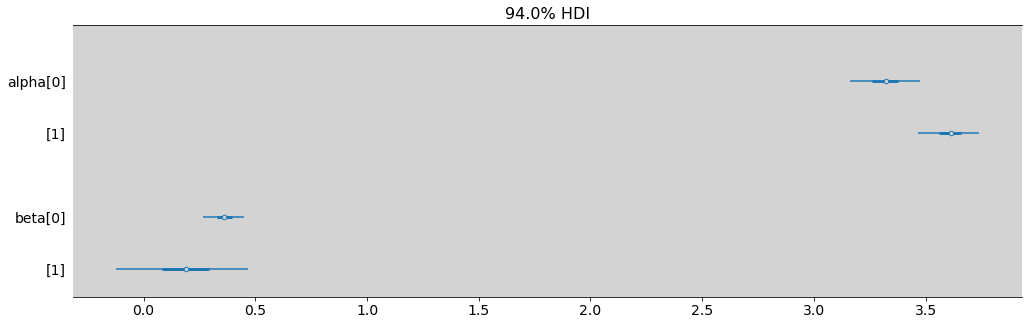

In [100]:
az.plot_forest(model_11_9_new_post, var_names=['alpha', 'beta'], combined=True, figsize=(17, 5))
plt.show()

### R Code 11.46

In [101]:
# Need to make a generated_quantities to compute compare


dict_to_compare = {
    'model_11_9_post': model_11_9_post,
    'model_11_9_new_post': model_11_9_new_post
}

# az.compare(dict_to_compare)

### R Code 11.47

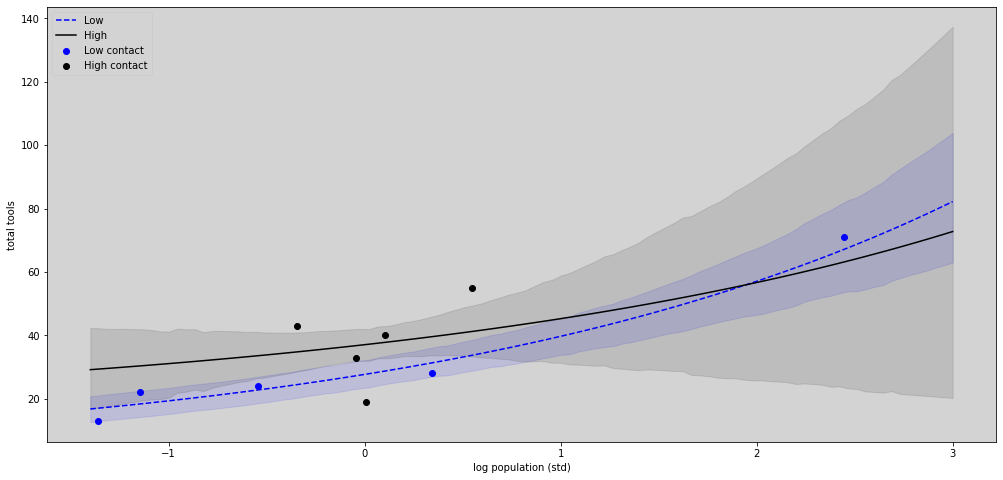

In [102]:
N = 100
a_low = model_11_9_new_post.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_9_new_post.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

a_high = model_11_9_new_post.posterior.alpha.sel(contact_id=1).values.flatten()  # CID = 1 (high contact) 
b_high = model_11_9_new_post.posterior.beta.sel(contact_id=1).values.flatten()  # CID = 1 (high contact)

x_seq = np.linspace(-1.4, 3, 100)  # log(population)

lambda_poisson_low =  np.array([ np.exp(a_low + b_low * x_seq[i]) for i in range(N)])
hdi_low = np.transpose([ az.hdi(lambda_poisson_low[i]) for i in range(N) ])
            
lambda_poisson_high =  np.array([ np.exp(a_high + b_high * x_seq[i]) for i in range(N)])
hdi_high = np.transpose([ az.hdi(lambda_poisson_high[i]) for i in range(N) ])

plt.figure(figsize=(17,8))

plt.plot(x_seq,lambda_poisson_low.mean(axis=1), c='blue', label='Low', ls='--')  # Low
plt.fill_between(x_seq, hdi_low[0], hdi_low[1], color='blue', alpha=0.1)

plt.plot(x_seq, lambda_poisson_high.mean(axis=1), c='black', label='High')  # High
plt.fill_between(x_seq, hdi_high[0], hdi_high[1], color='black', alpha=0.1)

# Plot the points
plt.scatter(df[df['contact_id'] == 1].P, df[df['contact_id'] == 1].total_tools, label='Low contact', color='blue')
plt.scatter(df[df['contact_id'] == 2].P, df[df['contact_id'] == 2].total_tools, label='High contact', color='black')

plt.title('')
plt.xlabel('log population (std)')
plt.ylabel('total tools')
plt.legend(loc='upper left')


plt.show()

### R Code 11.48

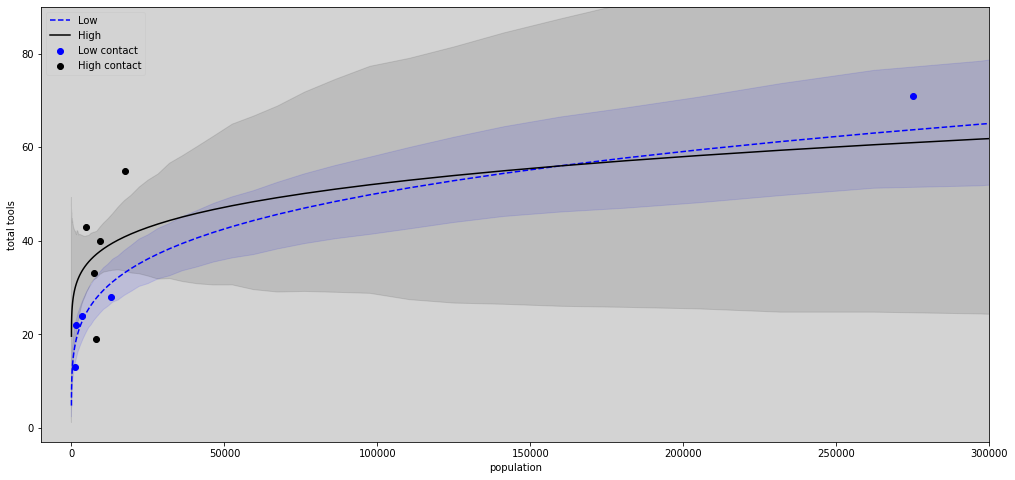

In [103]:
N = 100
a_low = model_11_9_new_post.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_9_new_post.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

a_high = model_11_9_new_post.posterior.alpha.sel(contact_id=1).values.flatten()  # CID = 1 (high contact) 
b_high = model_11_9_new_post.posterior.beta.sel(contact_id=1).values.flatten()  # CID = 1 (high contact)

p_seq = np.linspace(-5, 3, 100)

# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq = np.exp(p_seq * 1.53 + 9)

lambda_poisson_low =  np.array([ np.exp(a_low + b_low * p_seq[i]) for i in range(N)])
hdi_low = np.transpose([ az.hdi(lambda_poisson_low[i]) for i in range(N) ])
            
lambda_poisson_high =  np.array([ np.exp(a_high + b_high * p_seq[i]) for i in range(N)])
hdi_high = np.transpose([ az.hdi(lambda_poisson_high[i]) for i in range(N) ])

plt.figure(figsize=(17,8))

plt.plot(pop_seq,lambda_poisson_low.mean(axis=1), c='blue', label='Low', ls='--')  # Low
plt.fill_between(pop_seq, hdi_low[0], hdi_low[1], color='blue', alpha=0.1)

plt.plot(pop_seq, lambda_poisson_high.mean(axis=1), c='black', label='High')  # High
plt.fill_between(pop_seq, hdi_high[0], hdi_high[1], color='black', alpha=0.1)

# Plot the points
plt.scatter(df[df['contact_id'] == 1].population, df[df['contact_id'] == 1].total_tools, label='Low contact', color='blue')
plt.scatter(df[df['contact_id'] == 2].population, df[df['contact_id'] == 2].total_tools, label='High contact', color='black')

# Limits graphs
plt.xlim(-10000, 300000)
plt.ylim(-3, 90)

plt.title('')
plt.xlabel('population')
plt.ylabel('total tools')
plt.legend(loc='upper left')

plt.show()

### R Code 11.49 - Overthinking: Modeling tool innovation - Pg 356

Expected number of tools in one time step is:

$$ \Delta T = \alpha P^\beta - \gamma T $$


- $T$: Number of tools

- $\alpha, \beta, \gamma$: Parameters to be estimated

The equilibrium number of tools $T$, just $\Delta T = 0$ and solve for T.

$$ \hat{T} = \frac{\alpha P^\beta}{\gamma} $$

The noise around the outcome will still be $Poisson$, because that is still maximum entropy distribution in this context - `total_tools` is a count with no clear upper bound. The linear model is:

$$ T_i \sim Poisson(\lambda_i) $$

$$ \lambda_i = \frac{\alpha P^\beta_i}{\gamma} $$

In [104]:
N = 100

p_seq = np.linspace(df.log_population.min(), df.log_population.max(), N)

a = np.random.normal(1, 1, N)
b = np.random.exponential(1, N)
g = np.random.exponential(1, N)

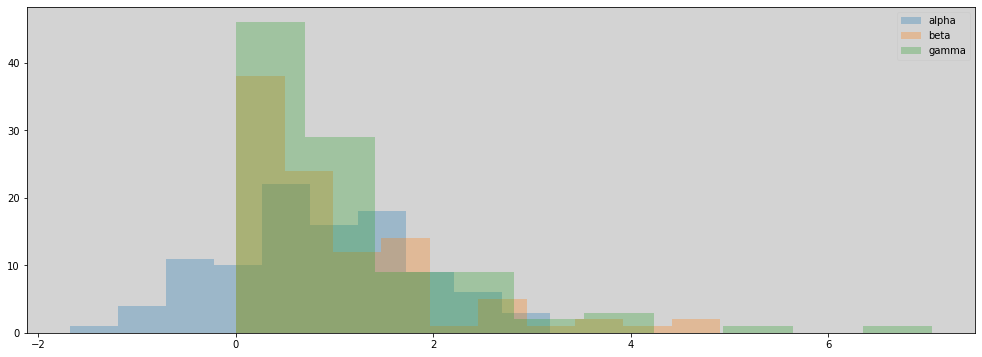

In [105]:
plt.figure(figsize=(17, 6))

plt.hist(a, alpha=0.3, label='alpha')
plt.hist(b, alpha=0.3, label='beta')
plt.hist(g, alpha=0.3, label='gamma')

plt.legend(loc='upper right')
plt.show()

In [106]:
np.shape(lambda_[0])

()

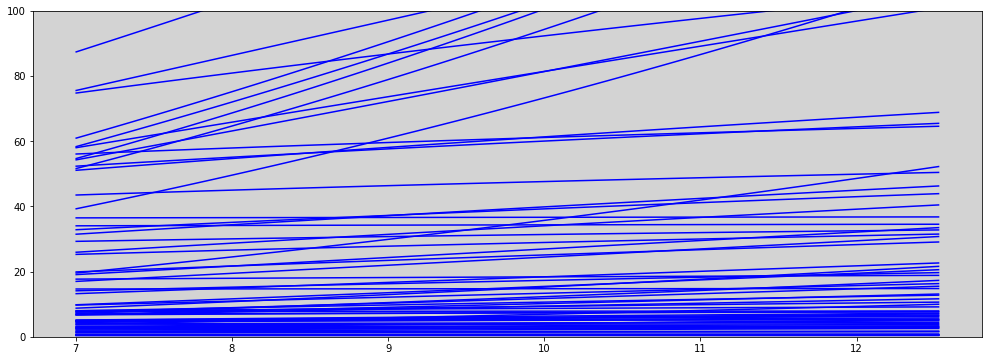

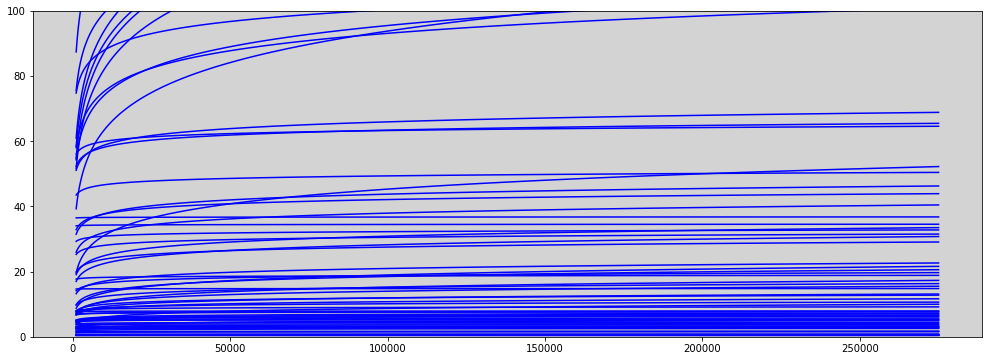

In [107]:
plt.figure(figsize=(17, 6))

lambda_ = [(np.exp(a[i]) * (p_seq ** b[i])) / g[i] for i in range(N)] 

for i in range(N):
    plt.plot(p_seq, lambda_[i], c='blue')
    
plt.ylim(0, 100)
plt.show()

plt.figure(figsize=(17, 6))
for i in range(N):
    plt.plot(np.exp(p_seq), lambda_[i], c='blue')
    
plt.ylim(0, 100)
plt.show()

In [108]:
model = """
    data {
        int N;
        int qty_cid;
        array[N] int total_tools;
        array[N] real population;
        array[N] int contact_id;
    }
    
    parameters {
        array[qty_cid] real alpha;
        array[qty_cid] real<lower=0> beta;
        real<lower=0> gamma;
    }
    
    model {
        array[N] real lambda;
        
        // Prioris
        alpha ~ normal(1, 1);
        beta ~ exponential(1);
        gamma ~ exponential(1);
        
        for(i in 1:N){
            lambda[i] = (exp(alpha[ contact_id[i] ]) * population[i] ^ beta[ contact_id[i] ])/gamma;
        }
        
        //likelihood
        total_tools ~ poisson(lambda);
    }
"""

data_list = df[["total_tools", "contact_id", "population"]].to_dict('list')
data_list['N'] = len(df.total_tools)
data_list['qty_cid'] = len(df.contact_id.unique())

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


Building: 11.8s


/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp: In constructor ‘model_bxhxlrbq_namespace::model_bxhxlrbq::model_bxhxlrbq(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp:57:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   57 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 11.9s


Building: 12.0s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.1s


Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp: In instantiation of ‘void model_bxhxlrbq_namespace::model_bxhxlrbq::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp:439:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp:302:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  302 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/bxhxlrbq/model_bxhxlrbq.cpp: In instantiation of ‘void model_bxhxlrbq_namespace::model_bxhxlrbq::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.6s


Building: 12.7s


Building: 12.8s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 12.9s


Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.8s


Building: 27.9s


Building: 28.0s


Building: 28.1s


Building: 28.2s


Building: 28.3s


Building: 28.4s


Building: 28.5s


Building: 28.6s


Building: 28.7s


Building: 28.8s


Building: 28.9s


Building: 29.0s


Building: 29.1s


Building: 29.2s


Building: 29.3s


Building: 29.4s


Building: 29.6s


Building: 29.7s


Building: 29.8s


Building: 29.9s


Building: 30.0s


RuntimeError: Event loop stopped before Future completed.

In [109]:
model_11_11 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
    dims = {
        'alpha': ['contact_id'],
        'beta': ['contact_id'],
    }
)

In [110]:
az.summary(model_11_11)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.917,0.685,-0.346,2.219,0.017,0.012,1681.0,1625.0,1.01
alpha[1],0.922,0.857,-0.682,2.488,0.020,0.015,1923.0,1648.0,1.00
beta[0],0.261,0.033,0.198,0.323,0.001,0.000,2336.0,1623.0,1.00
beta[1],0.292,0.106,0.084,0.481,0.003,0.002,1601.0,1392.0,1.00
gamma,1.164,0.776,0.107,2.514,0.019,0.013,1518.0,1454.0,1.00


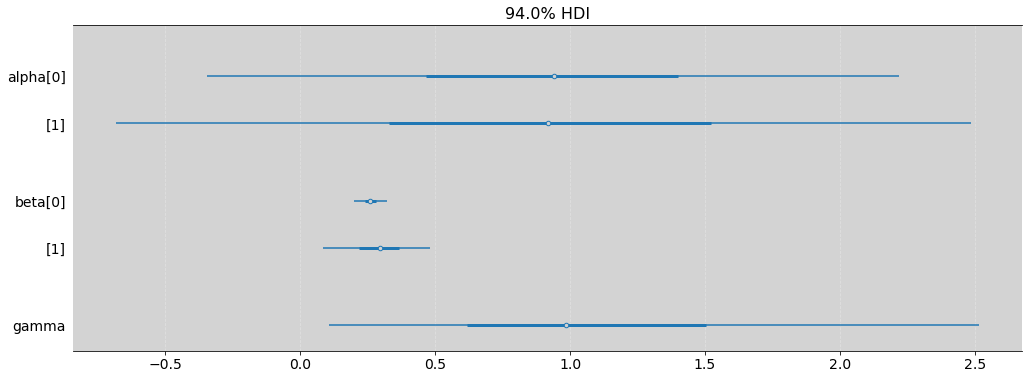

In [111]:
az.plot_forest(model_11_11, var_names=['alpha', 'beta', 'gamma'], combined=True, figsize=(17, 6))

plt.grid(axis='x', color='white', alpha=0.3, ls='--')

plt.show()

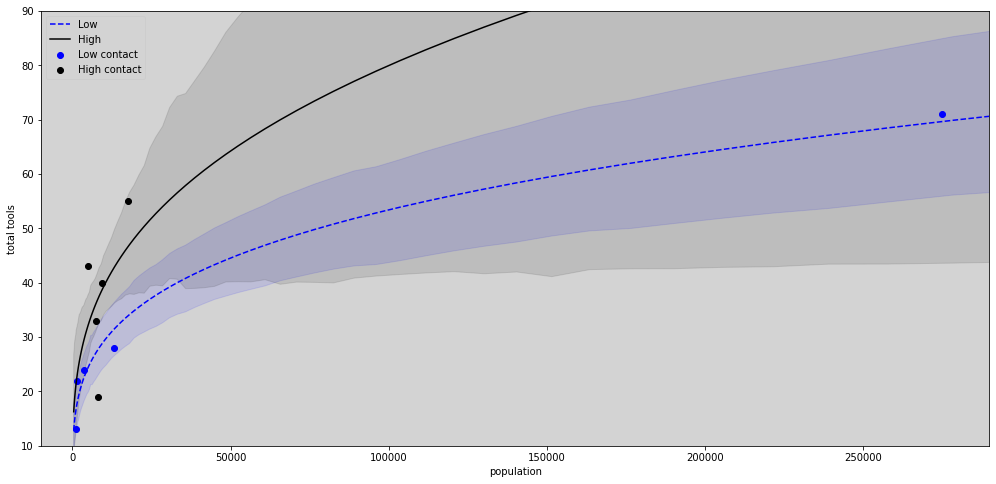

In [112]:
N = 100
a_low = model_11_11.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_11.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

a_high = model_11_11.posterior.alpha.sel(contact_id=1).values.flatten()  # CID = 1 (high contact) 
b_high = model_11_11.posterior.beta.sel(contact_id=1).values.flatten()  # CID = 1 (high contact)

g = model_11_11.posterior.gamma.values.flatten()


p_seq = np.linspace(df.log_population.min() -1 , df.log_population.max() + 1, N)

pop_seq = np.exp(p_seq)

lambda_poisson_low =  np.array([ (np.exp(a_low) * pop_seq[i] ** b_low)/g for i in range(N)])
hdi_low = np.transpose([ az.hdi(lambda_poisson_low[i]) for i in range(N) ])
            
lambda_poisson_high =  np.array([ (np.exp(a_high) * pop_seq[i] ** b_high)/g for i in range(N)])
hdi_high = np.transpose([ az.hdi(lambda_poisson_high[i]) for i in range(N) ])

plt.figure(figsize=(17,8))

plt.plot(pop_seq,lambda_poisson_low.mean(axis=1), c='blue', label='Low', ls='--')  # Low
plt.fill_between(pop_seq, hdi_low[0], hdi_low[1], color='blue', alpha=0.1)

plt.plot(pop_seq, lambda_poisson_high.mean(axis=1), c='black', label='High')  # High
plt.fill_between(pop_seq, hdi_high[0], hdi_high[1], color='black', alpha=0.1)

# Plot the points
plt.scatter(df[df['contact_id'] == 1].population, df[df['contact_id'] == 1].total_tools, label='Low contact', color='blue')
plt.scatter(df[df['contact_id'] == 2].population, df[df['contact_id'] == 2].total_tools, label='High contact', color='black')

# Limits graphs
plt.xlim(-10000, 290000)
plt.ylim(10, 90)

plt.title('')
plt.xlabel('population')
plt.ylabel('total tools')
plt.legend(loc='upper left')

plt.show()

## Example: Exposure and the offset:

Implicity, $\lambda$ is equal to an expexted number of events, $\mu$,  per unit time or distance, $\tau$.

This implies that $\lambda = \frac{\mu}{\tau}$.

$$ y_i \sim Poisson(\lambda_i) $$

$$ log \lambda_i = log \frac{\mu_i}{\tau_i} = \alpha + \beta x_i $$

$$ log \mu_i = \log \tau_i + \alpha + \beta x_i $$

The $\tau$ values are the "$exposures$". When $\tau_i=1$, then $log(\tau_i) = 0$ and we're back where we started.

Then the model with different exposures just by writing a model like:

$$ y_i \sim Poisson(\mu_i) $$

$$ log \mu_i = log \tau_i + \alpha + \beta x_i $$

### R Code 11.50

In [113]:
num_days = 30

y = np.random.poisson(lam=1.5 ,size=num_days)
y

array([4, 0, 0, 4, 3, 0, 2, 2, 2, 5, 0, 1, 3, 1, 4, 3, 3, 3, 3, 1, 2, 0,
       1, 1, 2, 1, 3, 4, 0, 0])

### R Code 11.51

In [114]:
num_weeks = 4

y_new = np.random.poisson(lam=0.5*7, size=num_weeks)
y_new

array([4, 2, 3, 3])

### R Code 11.52

In [115]:
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])

df = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
df

,y,days,monastery
0,4,1,0
1,0,1,0
2,0,1,0
3,4,1,0
4,3,1,0
5,0,1,0
6,2,1,0
7,2,1,0
8,2,1,0
9,5,1,0


### R Code 11.52

In [116]:
model = """
    data {
        int N;
        array[N] int y;
        array[N] real log_days;
        array[N] int monastery;
    }
    
    parameters {
        real alpha;
        real beta;
    }
    
    model {
        array[N] real lambda;
        
        alpha ~ normal(0, 1);
        beta ~ normal(0, 1);
        
        for (i in 1:N){
            lambda[i] = log_days[i] + alpha + monastery[i] * beta ;
            lambda[i] = exp(lambda[i]);
        }
        
        y ~poisson(lambda);
    }
"""

df['log_days'] = np.log(df['days'])

data_list = df[['y', 'log_days', 'monastery']].to_dict('list')
data_list['N'] = len(df)

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!


In [117]:
model_11_12 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys())
)

### R Code 11.54

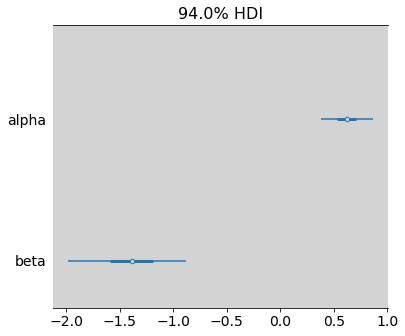

In [118]:
az.plot_forest(model_11_12, var_names=["alpha", "beta"], combined=True)
plt.show()

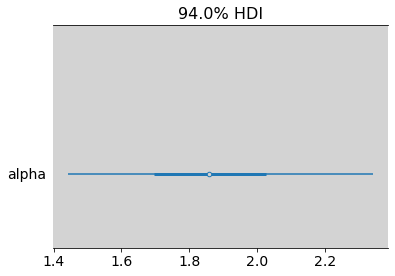

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.871,0.244,1.444,2.34,0.005,0.004,2097.0,1945.0,1.0


In [119]:
alpha = model_11_12.posterior.alpha
beta = model_11_12.posterior.beta

lambda_old = np.exp(alpha)
lambda_new = np.exp(alpha + beta)


az.plot_forest(lambda_old, var_names=['alpha'], combined=True)
plt.show()
az.summary(lambda_old)

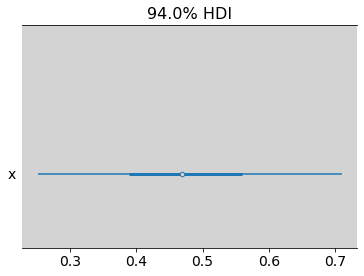

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.479,0.126,0.251,0.71,0.002,0.002,3170.0,2567.0,1.0


In [120]:
az.plot_forest(lambda_new, combined=True)
plt.show()

az.summary(lambda_new)

## Predictors matched to outcomes

In [121]:
def softmax(scores_list):
    return np.exp(scores_list) / np.sum(np.exp(scores_list))

### R Code 11.55

In [122]:
# Simulate career choices among 500 individuals

N = 500  # number individuals
income = np.array([1, 2, 5])  # expected income of each career
score = income * 0.5  # scores for each career, based on income

# next line converts scores to probabilities
p = softmax([score[0], score[1], score[2]])

career = [np.random.choice([1, 2, 3], size=1, p=p)[0] for _ in range(N)]

print('Career choiced: ', career[:20], '\nIncome: ', income, '\nScore:  ', score)

Career choiced:  [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3] 
Income:  [1 2 5] 
Score:   [0.5 1.  2.5]


 ### R Code 11.56

In [123]:
model = """
    data {
        int N;  // number of individuals - Here is 500
        int K;  // number of possible careers - Here is 3
        
        array[N] int career;  // outcome
        vector[K]  career_income;
    }
    
    parameters {
        vector[K-1] a;  // intercepts
        real<lower=0> b;  // association of income with choice
    }
    
    model {
        vector[K] p;
        vector[K] s;
        
        a ~ normal(0, 1);
        b ~ normal(0, 0.5);
        
        s[1] = a[1] + b * career_income[1];
        s[2] = a[2] + b * career_income[2];
        s[3] = 0;  // pivot
        
        p = softmax( s );
        
        career ~ categorical(p);
    }
"""

dat_list = dict({
    'N': len(career), # 500
    'K': len(score),  # 3
    'career': career,
    'career_income': income,
})

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


### R Code 11.57

In [124]:
np.std(samples['a'][0])

0.16525252892399064

In [125]:
model_11_13 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(dat_list.keys()),
)

In [126]:
az.summary(model_11_13)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-2.073,0.165,-2.423,-1.808,0.007,0.005,668.0,608.0,1.01
a[1],-1.730,0.216,-2.145,-1.361,0.011,0.008,436.0,429.0,1.00
b,0.122,0.096,0.000,0.299,0.005,0.004,431.0,569.0,1.00


obs: This model not fitting like a book!

*TODO*: Read this in future!

Explanations:
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

The model described in the book does not sample well in PyMC. It does slightly better if we change the pivot category to be the first career instead of the third, but this is still suboptimal because we are discarding predictive information from the pivoted category (i.e., its unique career income).

In fact, it is not necessary to pivot the coefficients of variables that are distinct for each category (what the author calls predictors matched to outcomes), as it is done for the coefficients of shared variables (what the author calles predictors matched to observations). The intercepts belong to the second category, and as such they still need to be pivoted. These two references explain this distinction clearly:

Hoffman, S. D., & Duncan, G. J. (1988). Multinomial and conditional logit discrete-choice models in demography. Demography, 25(3), 415-427 [pdf link](https://www.jstor.org/stable/pdf/2061541.pdf)
Croissant, Y. (2020). Estimation of Random Utility Models in R: The mlogit Package. Journal of Statistical Software, 95(1), 1-41 pdf [pdf link](https://www.jstatsoft.org/index.php/jss/article/view/v095i11/v95i11.pdf)

### R Code 11.58

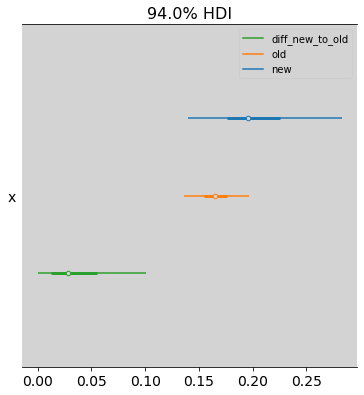

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.038,0.033,0.0,0.101,0.002,0.001,436.0,554.0,NaN


In [127]:
a = model_11_13.posterior.a
b = model_11_13.posterior.b


s1 = (a.sel(a_dim_0=0) + b * income[0]).values.flatten()
s2_old = (a.sel(a_dim_0=1) + b * income[1]).values.flatten()
s2_new = (a.sel(a_dim_0=1) + b * income[1] * 2).values.flatten()

p_orig = [softmax([s1[i], s2_old[i], 0]) for i in range(len(s1)) ]
p_new  = [softmax([s1[i], s2_new[i], 0]) for i in range(len(s1)) ]

# Summarize
p_diff = np.transpose(p_new)[1] - np.transpose(p_orig)[1]

az.plot_forest([np.transpose(p_new)[1], np.transpose(p_orig)[1], p_diff], model_names=['new', 'old', 'diff_new_to_old'])
plt.show()

az.summary(p_diff)

So on average a $5\%$ increase in probability of choosing the career, when the income is doubled.

## Predictors Matched to observations (pg 362)

### R Code 11.59

In [128]:
N = 500

# Simulate family incomes for each individual
family_income = np.random.uniform(0, 1, N)

b = np.array([-2, 0, 2])
career = np.empty(N)

for i in range(N):
    score = np.array([1, 2, 3]) * 0.5 + b * family_income[i]
    p = softmax([score[0], score[1], score[2]])
    career[i] = np.random.choice([1, 2, 3], size=1, p=p)
    
career = career.astype(int)
print('Career choiced: ', career[:15])
print('Family Income: ', family_income[:5])

Career choiced:  [3 3 1 3 3 3 3 2 3 3 2 3 2 3 3]
Family Income:  [0.88220597 0.26090131 0.41481564 0.95091294 0.31800893]


In [129]:
model = """
    data{
        int N;
        int K;
        array[N] int career;
        array[N] real family_income;
    }
    
    parameters {
        vector[K-1] a; // intercepts
        vector[K-1] b; // coefficients on family income
    }
    
    model {
        vector[K] p;
        vector[K] s;
        
        a ~ normal(1, 1.5);
        b ~ normal(0, 1);
        
        for (i in 1:N) {
            for (j in 1:(K-1)) s[j] = a[j] + b[j]*family_income[i];
            s[K] = 0;
            p = softmax( s );
            career[i] ~ categorical( p );
        }
    }
"""

dat_list = {
    'N': N,
    'K': len(b),
    'career': career,
    'family_income': family_income,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   5% (402/8000)
Sampling:   8% (601/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  58% (4600/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000368 seconds
  1000 transitions using 10 leapfrog steps per 

In [130]:
model_11_14 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
)

In [131]:
az.summary(model_11_14)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.306,0.266,-1.802,-0.812,0.006,0.004,2149.0,2219.0,1.0
a[1],-0.639,0.201,-1.019,-0.270,0.004,0.003,2279.0,2078.0,1.0
b[0],-2.276,0.550,-3.329,-1.255,0.012,0.008,2176.0,2278.0,1.0
b[1],-1.536,0.383,-2.263,-0.826,0.008,0.006,2294.0,1994.0,1.0


## Multinomial disguise as Poisson

### R Code 11.60

In [132]:
df = pd.read_csv('./data/UCBadmit.csv', sep=';')
df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [133]:
df.admit.values

array([512,  89, 353,  17, 120, 202, 138, 131,  53,  94,  22,  24])

In [134]:
model_bin = """
    data{
        int N;
        array[N] int admit;
        array[N] int applications;
    }
    
    parameters {
        real a;
    }
    
    model {
        real p;
        
        a ~ normal(0, 1.5);
        p = inv_logit(a);
        
        admit ~ binomial(applications, p);
    }
"""

dat_list_bin = {
    'N': len(df),
    'admit': df.admit.values,
    'applications': df.applications.values,
}

posteriori_bin = stan.build(model_bin, data=dat_list_bin)
samples_bin = posteriori_bin.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


In [135]:
m_bin = az.from_pystan(
    posterior=samples_bin,
    posterior_model=posteriori_bin 
)

### R Code 11.62

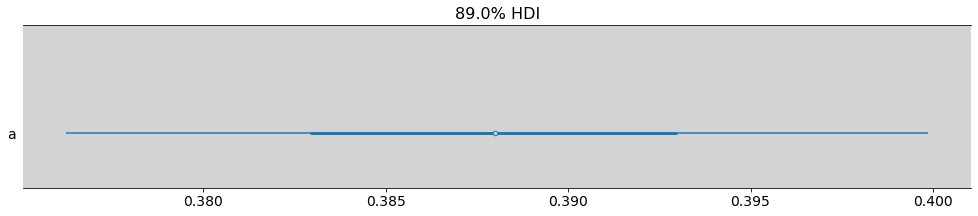

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.388,0.007,0.374,0.402,0.0,0.0,1343.0,1691.0,1.0


In [136]:
az.plot_forest(
    m_bin,
    var_names=['a'],
    combined=True,
    transform=inv_logit,
    figsize=(17, 3),
    hdi_prob=0.89,
)
plt.show()

az.summary(inv_logit(m_bin.posterior.a))

In [137]:
# RCode 11.61 - Poisson model

model_poi = """
    data{
        int N;
        array[N] int admit;
        array[N] int rej;
        array[N] int applications;
    }
    
    parameters {
        real a1;
        real a2;
    }
    
    model {
        real lambda_1;
        real lambda_2;
        
        a1 ~ normal(0, 1.5);
        a2 ~ normal(0, 1.5);
        
        lambda_1 = exp(a1);
        lambda_2 = exp(a2);
        
        admit ~ poisson(lambda_1);
        rej ~ poisson(lambda_2);
    }
"""

dat_list_poi = {
    'N': len(df),
    'admit': df.admit.values,
    'rej': df.reject.values,
    'applications': df.applications.values,
}

posteriori_poi = stan.build(model_poi, data=dat_list_poi)
samples_poi = posteriori_poi.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


In [138]:
m_poi = az.from_pystan(
    posterior=samples_poi,
    posterior_model=posteriori_poi 
)

### R Code 11.63

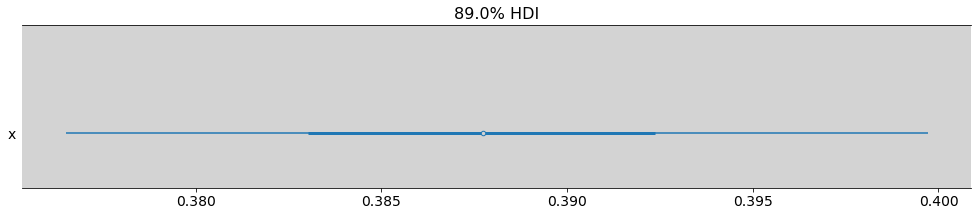

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.388,0.007,0.374,0.401,0.0,0.0,3787.0,2203.0,1.0


In [139]:
lam1 = np.exp(m_poi.posterior.a1)
lam2 = np.exp(m_poi.posterior.a2)

resp = lam1 / (lam1 + lam2)

az.plot_forest(resp, 
               combined=True,
               figsize=(17, 3),
               hdi_prob=0.89)
plt.show()

az.summary(resp)